In [1]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def model1_competition(P, t, r, C):
    """
    Lotka-Volterra competition model.
    P = [P1, P2, P3] (current populations)
    t = time
    r = [r1, r2, r3] (intrinsic growth rates)
    C = carrying capacity
    """
    
    # Unpack populations
    P1, P2, P3 = P
    
    # Calculate total population
    N = P1 + P2 + P3
    
    # Calculate the competition term (logistic factor)
    # Use max(0, ...) to prevent negative growth if N > C
    logistic_term = max(0, (1 - N / C))
    
    # Calculate dP/dt for each species
    dP1_dt = r[0] * P1 * logistic_term
    dP2_dt = r[1] * P2 * logistic_term
    dP3_dt = r[2] * P3 * logistic_term
    
    return [dP1_dt, dP2_dt, dP3_dt]

In [3]:
r = [0.3, 0.5, 0.8]  # r1, r2, r3
C = 1000.0           # Carrying capacity
P0 = [10.0, 10.0, 10.0] # Initial populations [P1, P2, P3]

# 3. Set up Time
t = np.linspace(0, 50, 500) # Time from 0 to 50

# 4. Solve the ODE
solution = odeint(model1_competition, P0, t, args=(r, C))

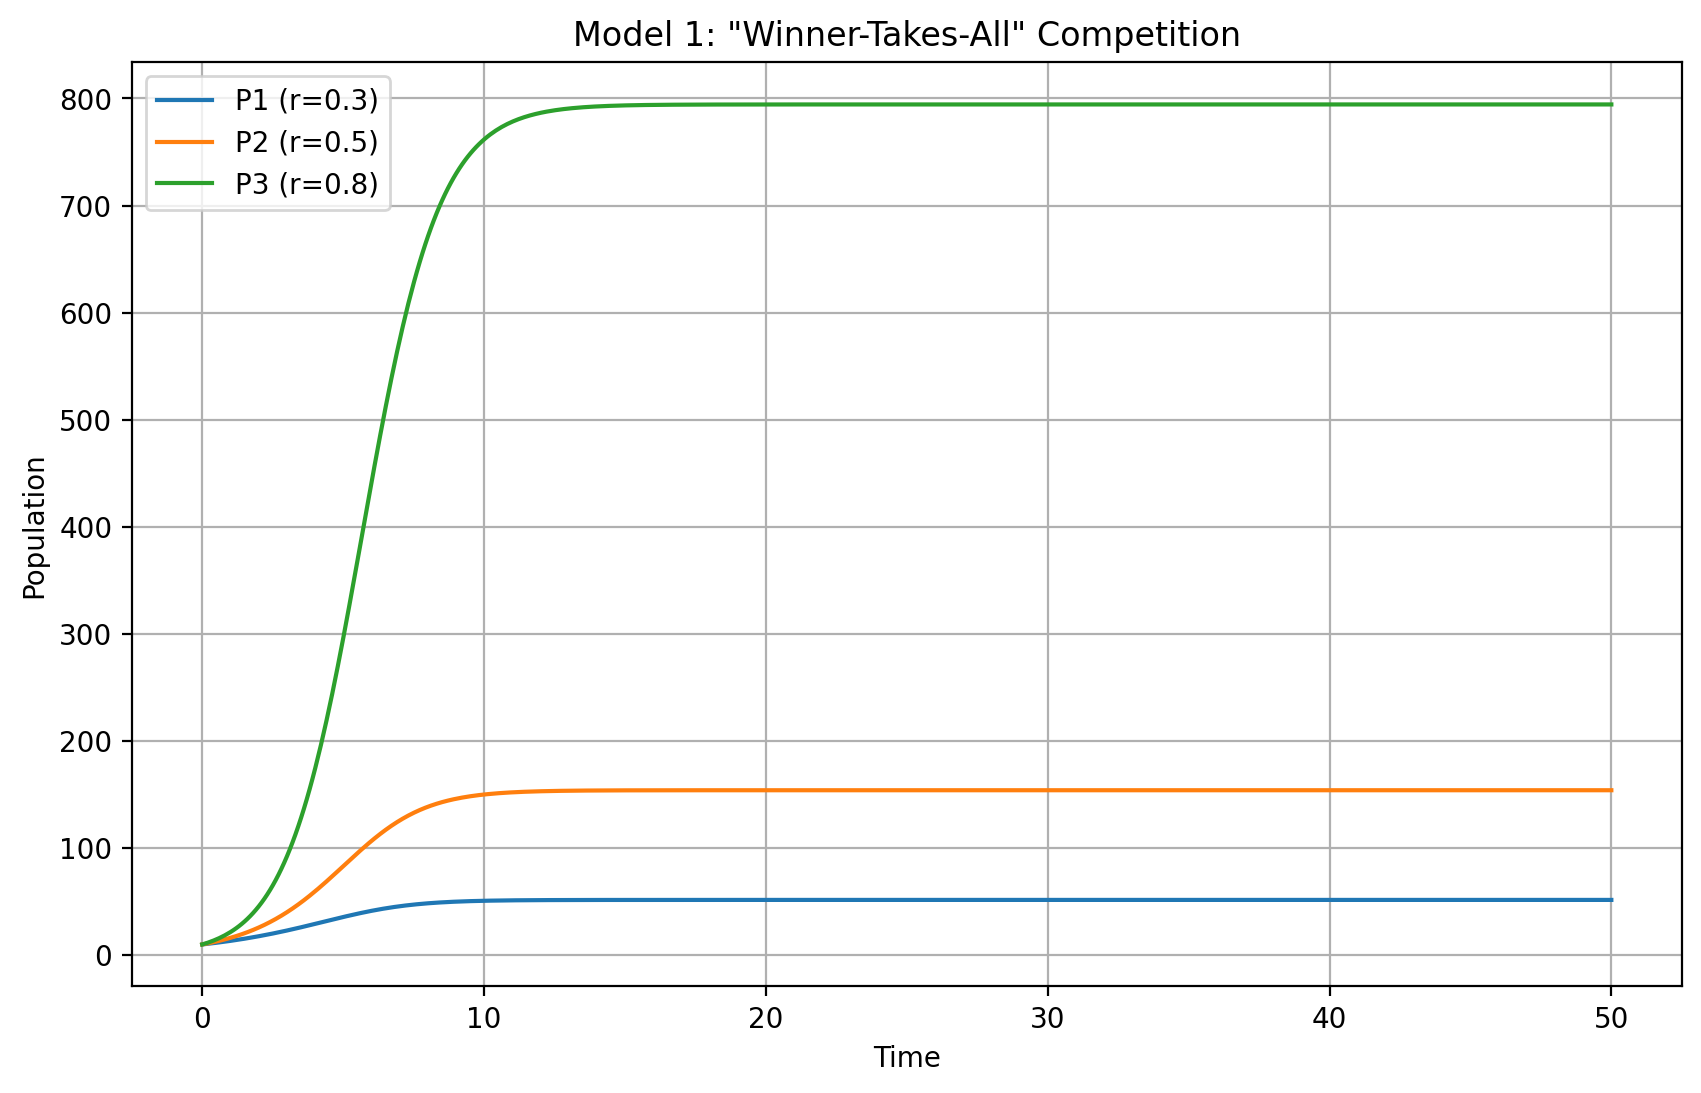

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(t, solution[:, 0], label='P1 (r=0.3)')
plt.plot(t, solution[:, 1], label='P2 (r=0.5)')
plt.plot(t, solution[:, 2], label='P3 (r=0.8)')
plt.title('Model 1: "Winner-Takes-All" Competition')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
def model2_evolution(P, t, R, D, M, C):
    """
    Evolutionary network model (quasispecies).
    P = [P1, P2, P3] (current populations)
    t = time
    R = [R1, R2, R3] (replication rates)
    D = [D1, D2, D3] (death rates)
    M = [M1, M2] (mutation rates P1->P2, P2->P3)
    C = carrying capacity
    """
    
    # Unpack populations
    P1, P2, P3 = P
    
    # Calculate total population
    N = P1 + P2 + P3
    
    # Calculate the resource-limited replication term
    logistic_term = max(0, (1 - N / C))
    
    # --- Calculate dP/dt for each species ---
    
    # P1: Gains from perfect copies, loses to death
    dP1_dt = P1 * R[0] * (1 - M[0]) * logistic_term - P1 * D[0]
    
    # P2: Gains from perfect copies AND P1 mutations, loses to death
    gain_P2_perfect = P2 * R[1] * (1 - M[1]) * logistic_term
    gain_P2_mutation = P1 * R[0] * M[0] * logistic_term
    loss_P2_death = P2 * D[1]
    dP2_dt = gain_P2_perfect + gain_P2_mutation - loss_P2_death
    
    # P3: Gains from perfect copies (M3=0) AND P2 mutations, loses to death
    gain_P3_perfect = P3 * R[2] * logistic_term # Assumes M3=0
    gain_P3_mutation = P2 * R[1] * M[1] * logistic_term
    loss_P3_death = P3 * D[2]
    dP3_dt = gain_P3_perfect + gain_P3_mutation - loss_P3_death
    
    return [dP1_dt, dP2_dt, dP3_dt]

In [6]:
R = [0.5, 0.8, 1.2]  # R1, R2, R3
D = [0.1, 0.1, 0.1]  # D1, D2, D3
M = [0.05, 0.05]      # M1 (P1->P2), M2 (P2->P3)
C = 1000.0           # Carrying capacity
P0 = [10.0, 0.0, 0.0]  # Initial populations [P1, P2, P3]

# 3. Set up Time
t = np.linspace(0, 100, 1000) # Time from 0 to 100 (needs longer)

# 4. Solve the ODE
solution = odeint(model2_evolution, P0, t, args=(R, D, M, C))

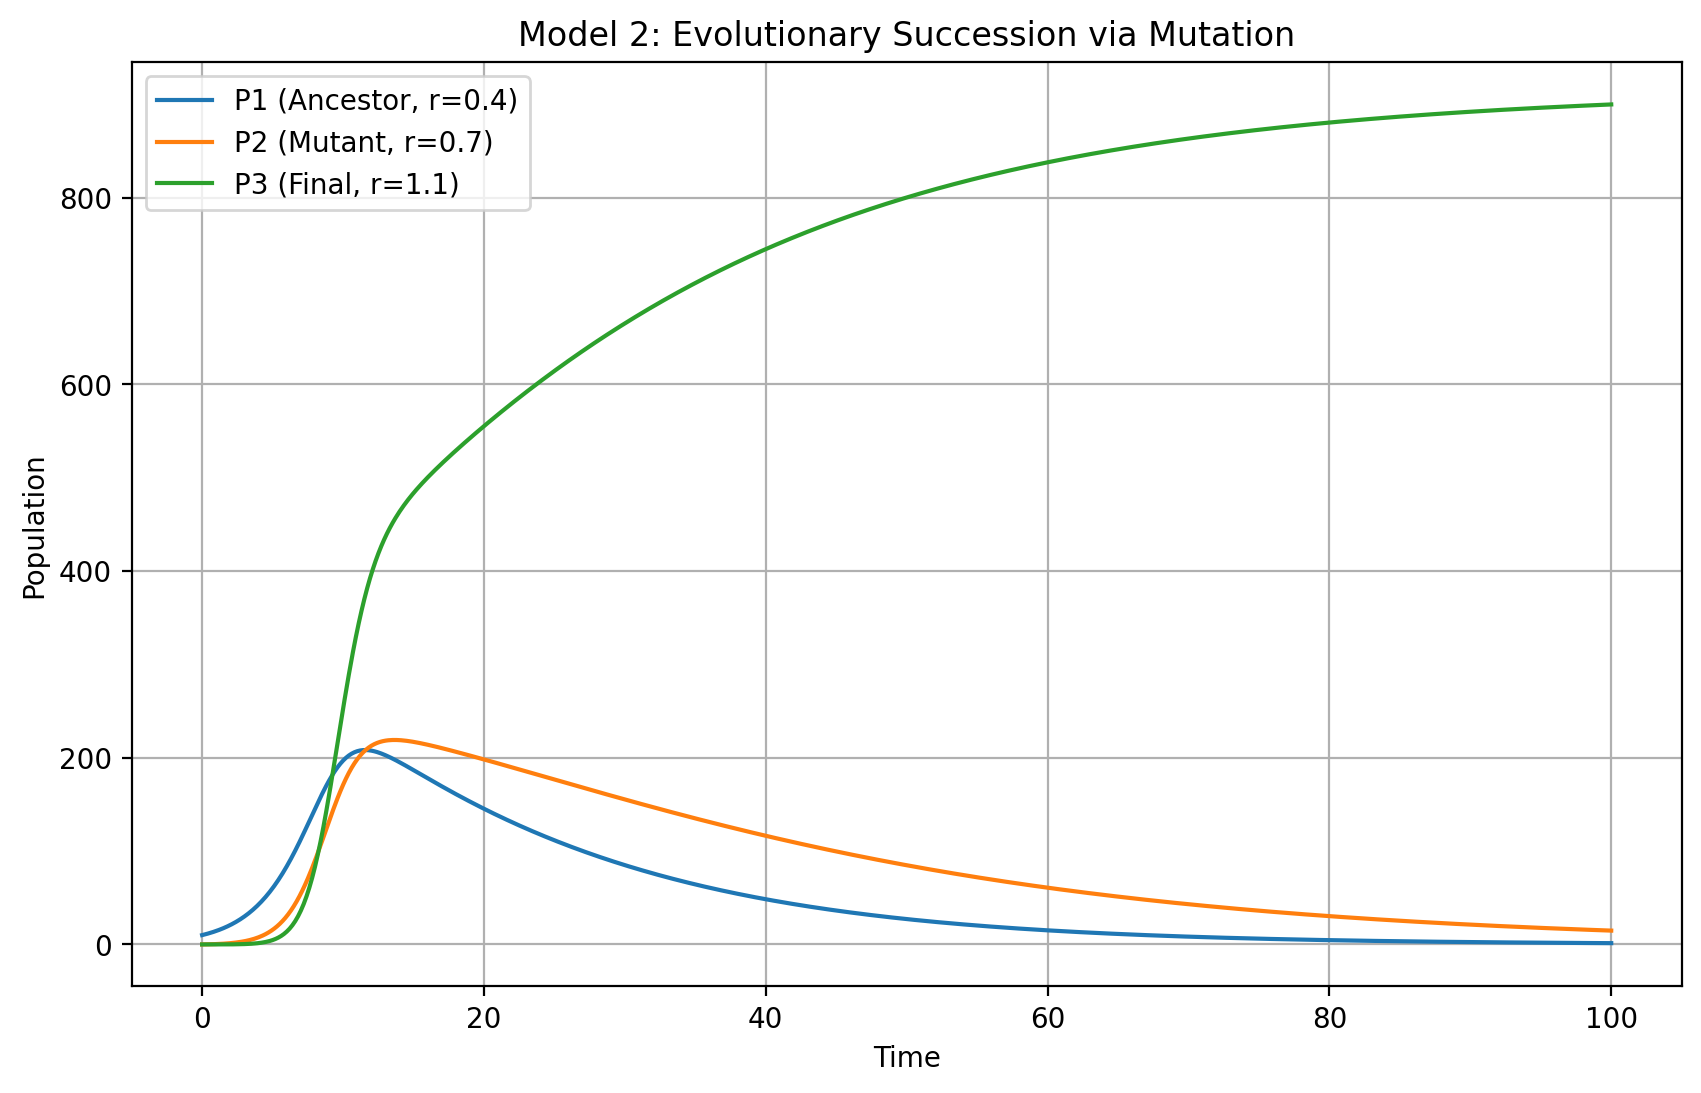

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(t, solution[:, 0], label='P1 (Ancestor, r=0.4)')
plt.plot(t, solution[:, 1], label='P2 (Mutant, r=0.7)')
plt.plot(t, solution[:, 2], label='P3 (Final, r=1.1)')
plt.title('Model 2: Evolutionary Succession via Mutation')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

### 3.6 Expected Results & Interpretation

**Key Observations**:
1. **Photostationary State**: During daylight, the system reaches a quasi-equilibrium where d[O₃]/dt ≈ 0
2. **Ozone Limitation**: In this simple model, ozone cannot accumulate significantly because NO immediately titrates it back to NO₂
3. **Diurnal Pattern**: Concentrations oscillate with solar radiation
4. **Conservation**: [NO] + [O₃] remains approximately constant (nitrogen conservation)

**Physical Insight**: This model shows the **basic photochemical cycle** but cannot explain high ozone episodes because it lacks the crucial ingredient: **VOCs (hydrocarbons)**. This motivates Model 2!

---

## **MODEL 2: Generic Reaction Set (GRS) - 7 Reactions**

### 4.1 Motivation
The simple cycle cannot produce net ozone. We need to include **Reactive Organic Compounds (ROCs)** that create radicals, which oxidize NO to NO₂ *without consuming ozone*.

### 4.2 Reaction Mechanism (from Document 1, Section 10.1.2)

This is the **GRS mechanism** - a simplified yet effective representation:
```
(R1) ROC + hν → RP                  (radical production, k₁)
(R2) RP + NO → NO₂                  (NO oxidation, k₂)
(R3) NO₂ + hν → NO + O              (photolysis, k₃)
(R4) O + O₂ → O₃                    (ozone formation, fast)
(R5) NO + O₃ → NO₂ + O₂             (titration, k₅)
(R6) RP + NO₂ → SGN                 (radical termination, k₆)
(R7) RP + RP → products             (radical recombination, k₇)
```

Where:
- **ROC** = Reactive Organic Compound (lumped VOCs)
- **RP** = Radical Pool (HO•, HO₂•, RO₂• combined)
- **SGN** = Stable Gaseous Nitrogen (HNO₃, organic nitrates)

### 4.3 Mathematical Formulation

**State Variables**: [NO], [NO₂], [O₃], [ROC], [RP]

**Differential Equations**:
```
d[NO]/dt = k₃[NO₂] - k₂[RP][NO] - k₅[NO][O₃] + E_NO

d[NO₂]/dt = -k₃[NO₂] + k₂[RP][NO] + k₅[NO][O₃] - k₆[RP][NO₂] + E_NO2

d[O₃]/dt = k₄[O][O₂] - k₅[NO][O₃]

d[ROC]/dt = -k₁[ROC] + E_ROC

d[RP]/dt = k₁[ROC] - k₂[RP][NO] - k₆[RP][NO₂] - 2k₇[RP]²
```

**Assumptions**:
- Atomic oxygen O in pseudo-steady state: [O] ≈ k₃[NO₂]/k₄[O₂]
- [O₂] constant
- Emission rates E_i for primary pollutants

**Simplified** (substituting for O):
```
d[NO]/dt = k₃[NO₂] - k₂[RP][NO] - k₅[NO][O₃] + E_NO

d[NO₂]/dt = -k₃[NO₂] + k₂[RP][NO] + k₅[NO][O₃] - k₆[RP][NO₂] + E_NO2

d[O₃]/dt = k₃[NO₂] - k₅[NO][O₃]

d[ROC]/dt = -k₁[ROC] + E_ROC

d[RP]/dt = k₁[ROC] - k₂[RP][NO] - k₆[RP][NO₂] - 2k₇[RP]²
```

In [8]:
T = 298  # Temperature in K
k3 = 3.1e3 * np.exp(-1450/T)  # ppm^-1 min^-1

def k1(t):
    """Photolysis rate - depends on solar radiation"""
    if 6 <= t <= 18:
        return 0.508 * np.sin(np.pi * (t - 6) / 12)
    else:
        return 0.0

def model1(y, t):
    """
    Model 1: Simple NO-NO2-O3 cycle
    y = [NO, NO2, O3]
    """
    NO, NO2, O3 = y
    
    # Current photolysis rate
    k1_t = k1(t)
    
    # Differential equations
    dNO_dt = k1_t * NO2 - k3 * NO * O3
    dNO2_dt = -k1_t * NO2 + k3 * NO * O3
    dO3_dt = k1_t * NO2 - k3 * NO * O3
    
    return [dNO_dt, dNO2_dt, dO3_dt]

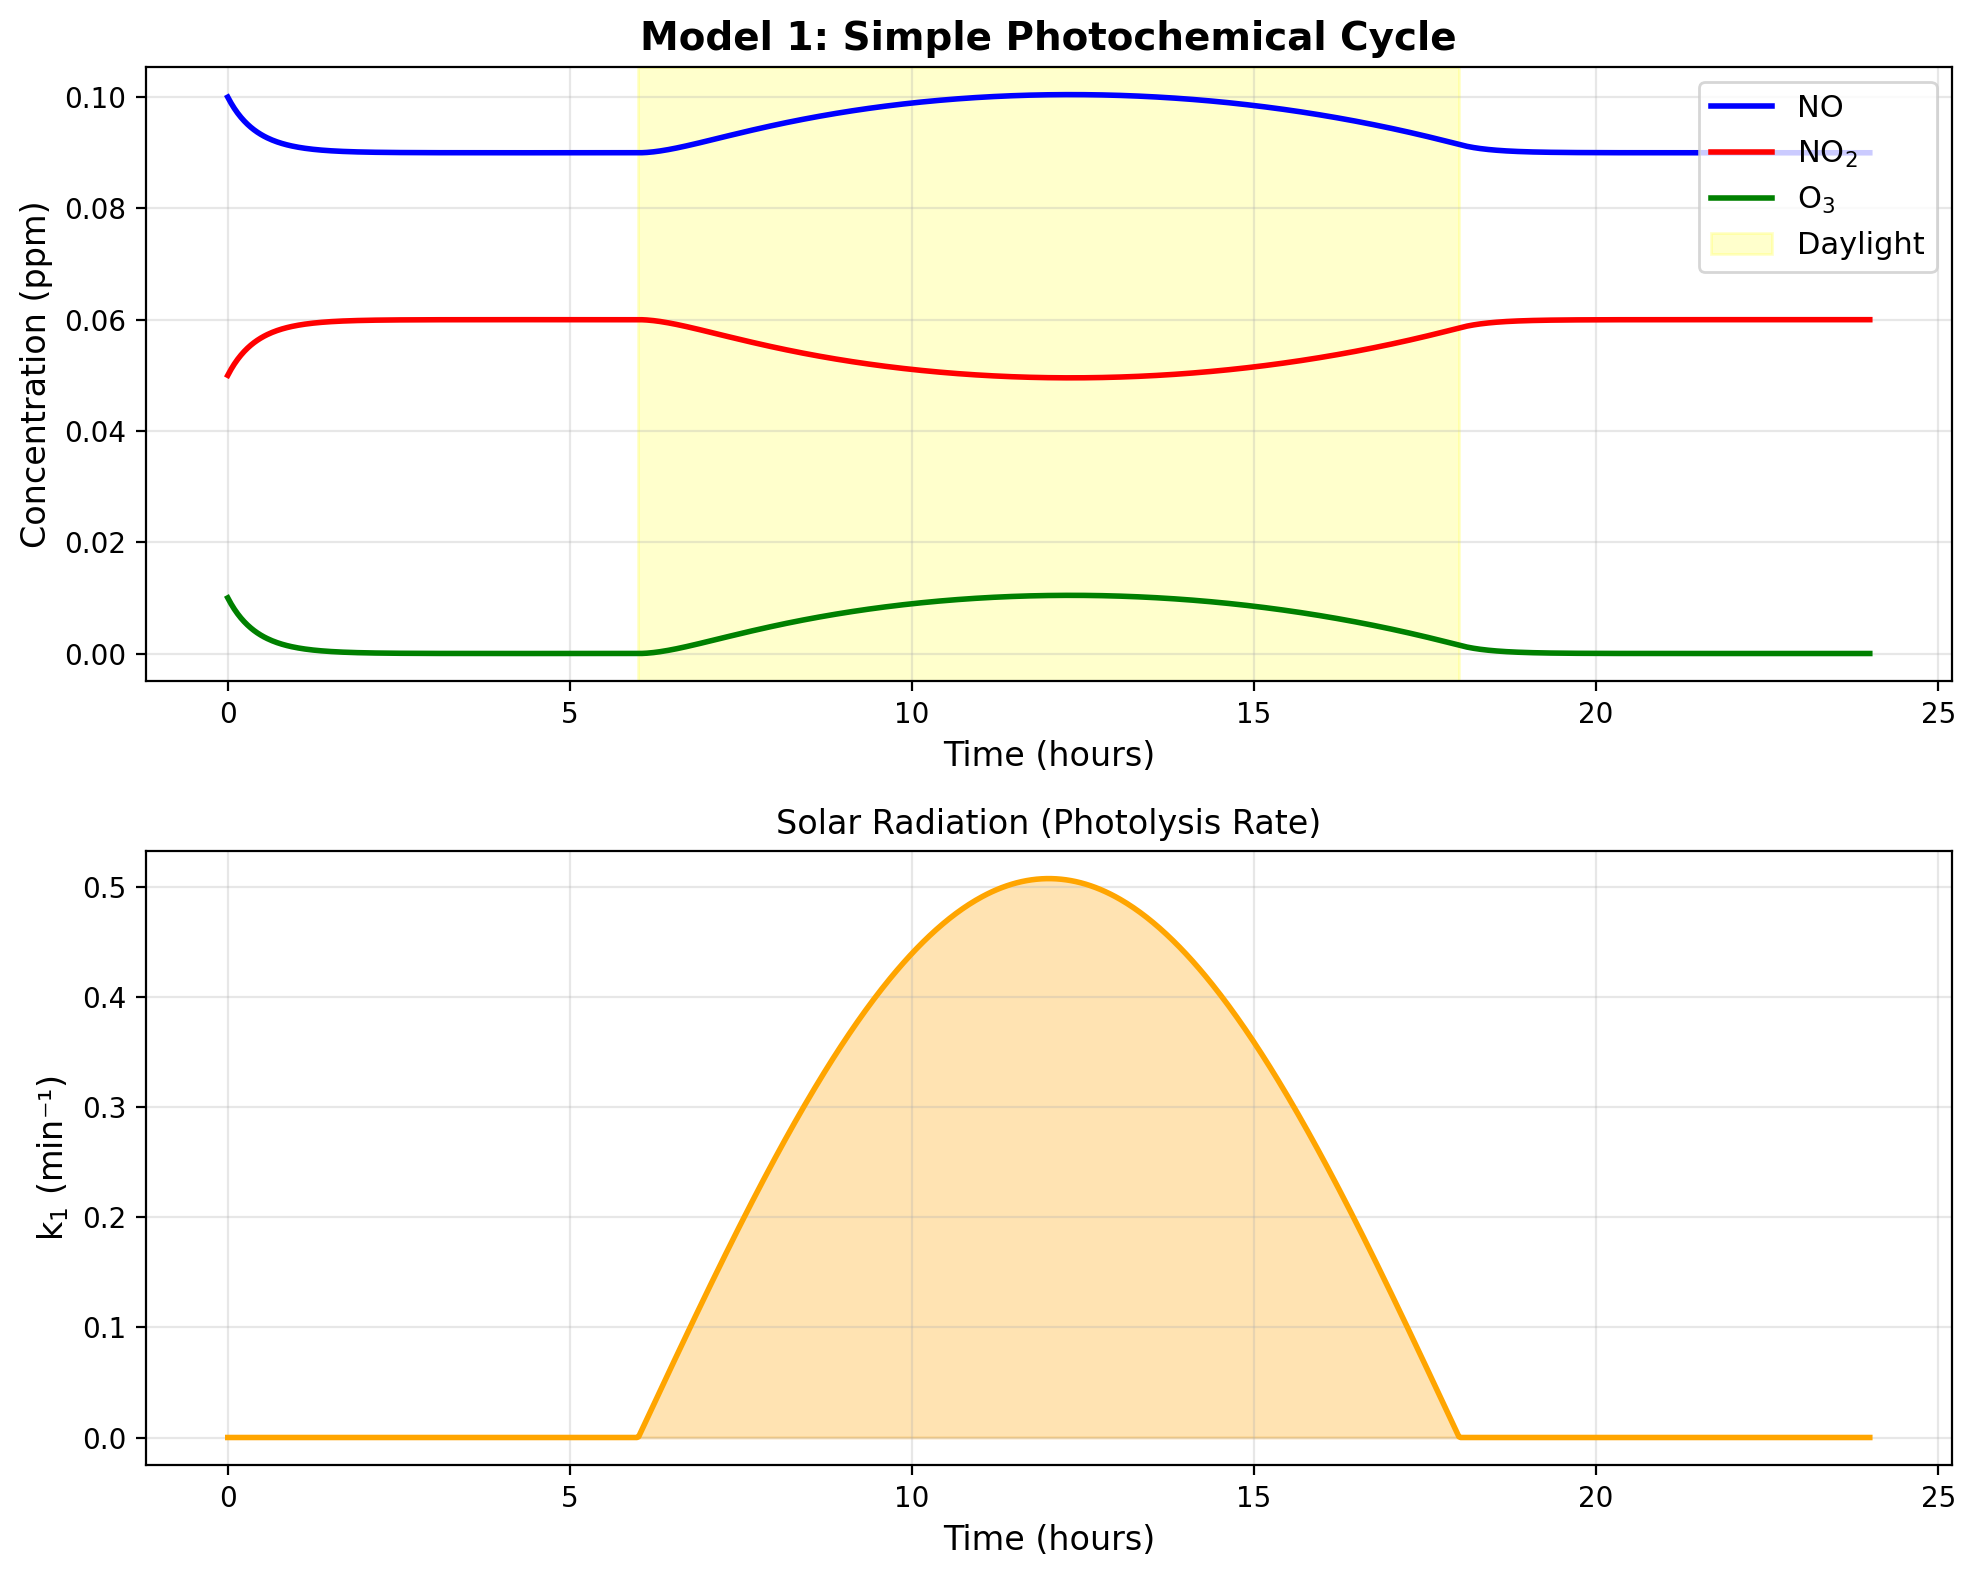

MODEL 1: SUMMARY STATISTICS

Initial concentrations:
  NO:  0.100 ppm
  NO₂: 0.050 ppm
  O₃:  0.010 ppm

Peak concentrations:
  NO:  0.100 ppm at t = 12.3 hrs
  NO₂: 0.060 ppm at t = 24.0 hrs
  O₃:  0.010 ppm at t = 12.3 hrs

Conservation check:
  Initial [NO] + [O₃] = 0.110 ppm
  Final [NO] + [O₃]   = 0.090 ppm


In [9]:
# Initial conditions
y0 = [0.1, 0.05, 0.01]  # [NO, NO2, O3] in ppm

# Time span (24 hours in minutes)
t = np.linspace(0, 24, 1000)

# Solve ODE
solution = odeint(model1, y0, t)

# Extract results
NO, NO2, O3 = solution.T

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot concentrations
ax1.plot(t, NO, 'b-', label='NO', linewidth=2)
ax1.plot(t, NO2, 'r-', label=r'NO$_2$', linewidth=2)
ax1.plot(t, O3, 'g-', label=r'O$_3$', linewidth=2)
ax1.axvspan(6, 18, alpha=0.2, color='yellow', label='Daylight')
ax1.set_xlabel('Time (hours)', fontsize=12)
ax1.set_ylabel('Concentration (ppm)', fontsize=12)
ax1.set_title('Model 1: Simple Photochemical Cycle', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot photolysis rate
k1_values = [k1(ti) for ti in t]
ax2.plot(t, k1_values, 'orange', linewidth=2)
ax2.fill_between(t, k1_values, alpha=0.3, color='orange')
ax2.set_xlabel('Time (hours)', fontsize=12)
ax2.set_ylabel(r'k$_1$ (min⁻¹)', fontsize=12)
ax2.set_title('Solar Radiation (Photolysis Rate)', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('model1_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("=" * 50)
print("MODEL 1: SUMMARY STATISTICS")
print("=" * 50)
print(f"\nInitial concentrations:")
print(f"  NO:  {y0[0]:.3f} ppm")
print(f"  NO₂: {y0[1]:.3f} ppm")
print(f"  O₃:  {y0[2]:.3f} ppm")

print(f"\nPeak concentrations:")
print(f"  NO:  {NO.max():.3f} ppm at t = {t[NO.argmax()]:.1f} hrs")
print(f"  NO₂: {NO2.max():.3f} ppm at t = {t[NO2.argmax()]:.1f} hrs")
print(f"  O₃:  {O3.max():.3f} ppm at t = {t[O3.argmax()]:.1f} hrs")

print(f"\nConservation check:")
print(f"  Initial [NO] + [O₃] = {y0[0] + y0[2]:.3f} ppm")
print(f"  Final [NO] + [O₃]   = {NO[-1] + O3[-1]:.3f} ppm")
print("=" * 50)


PHOTOCHEMICAL SMOG MODELING PROJECT
From Simple to Complex Systems
Running Model 1: Simple Photochemical Cycle
Solving ODEs...
Peak O3: 0.0200 ppm at t = 0.0 hours
Peak NO2: 0.0780 ppm at t = 48.0 hours

Photostationary state check at noon (day 1):
  Predicted $\phi$ = k1/k3 = 0.0254 ppm
  Simulated $\phi$ = [NO][O3]/[NO2] = 0.0252 ppm
  Agreement: 99.1%


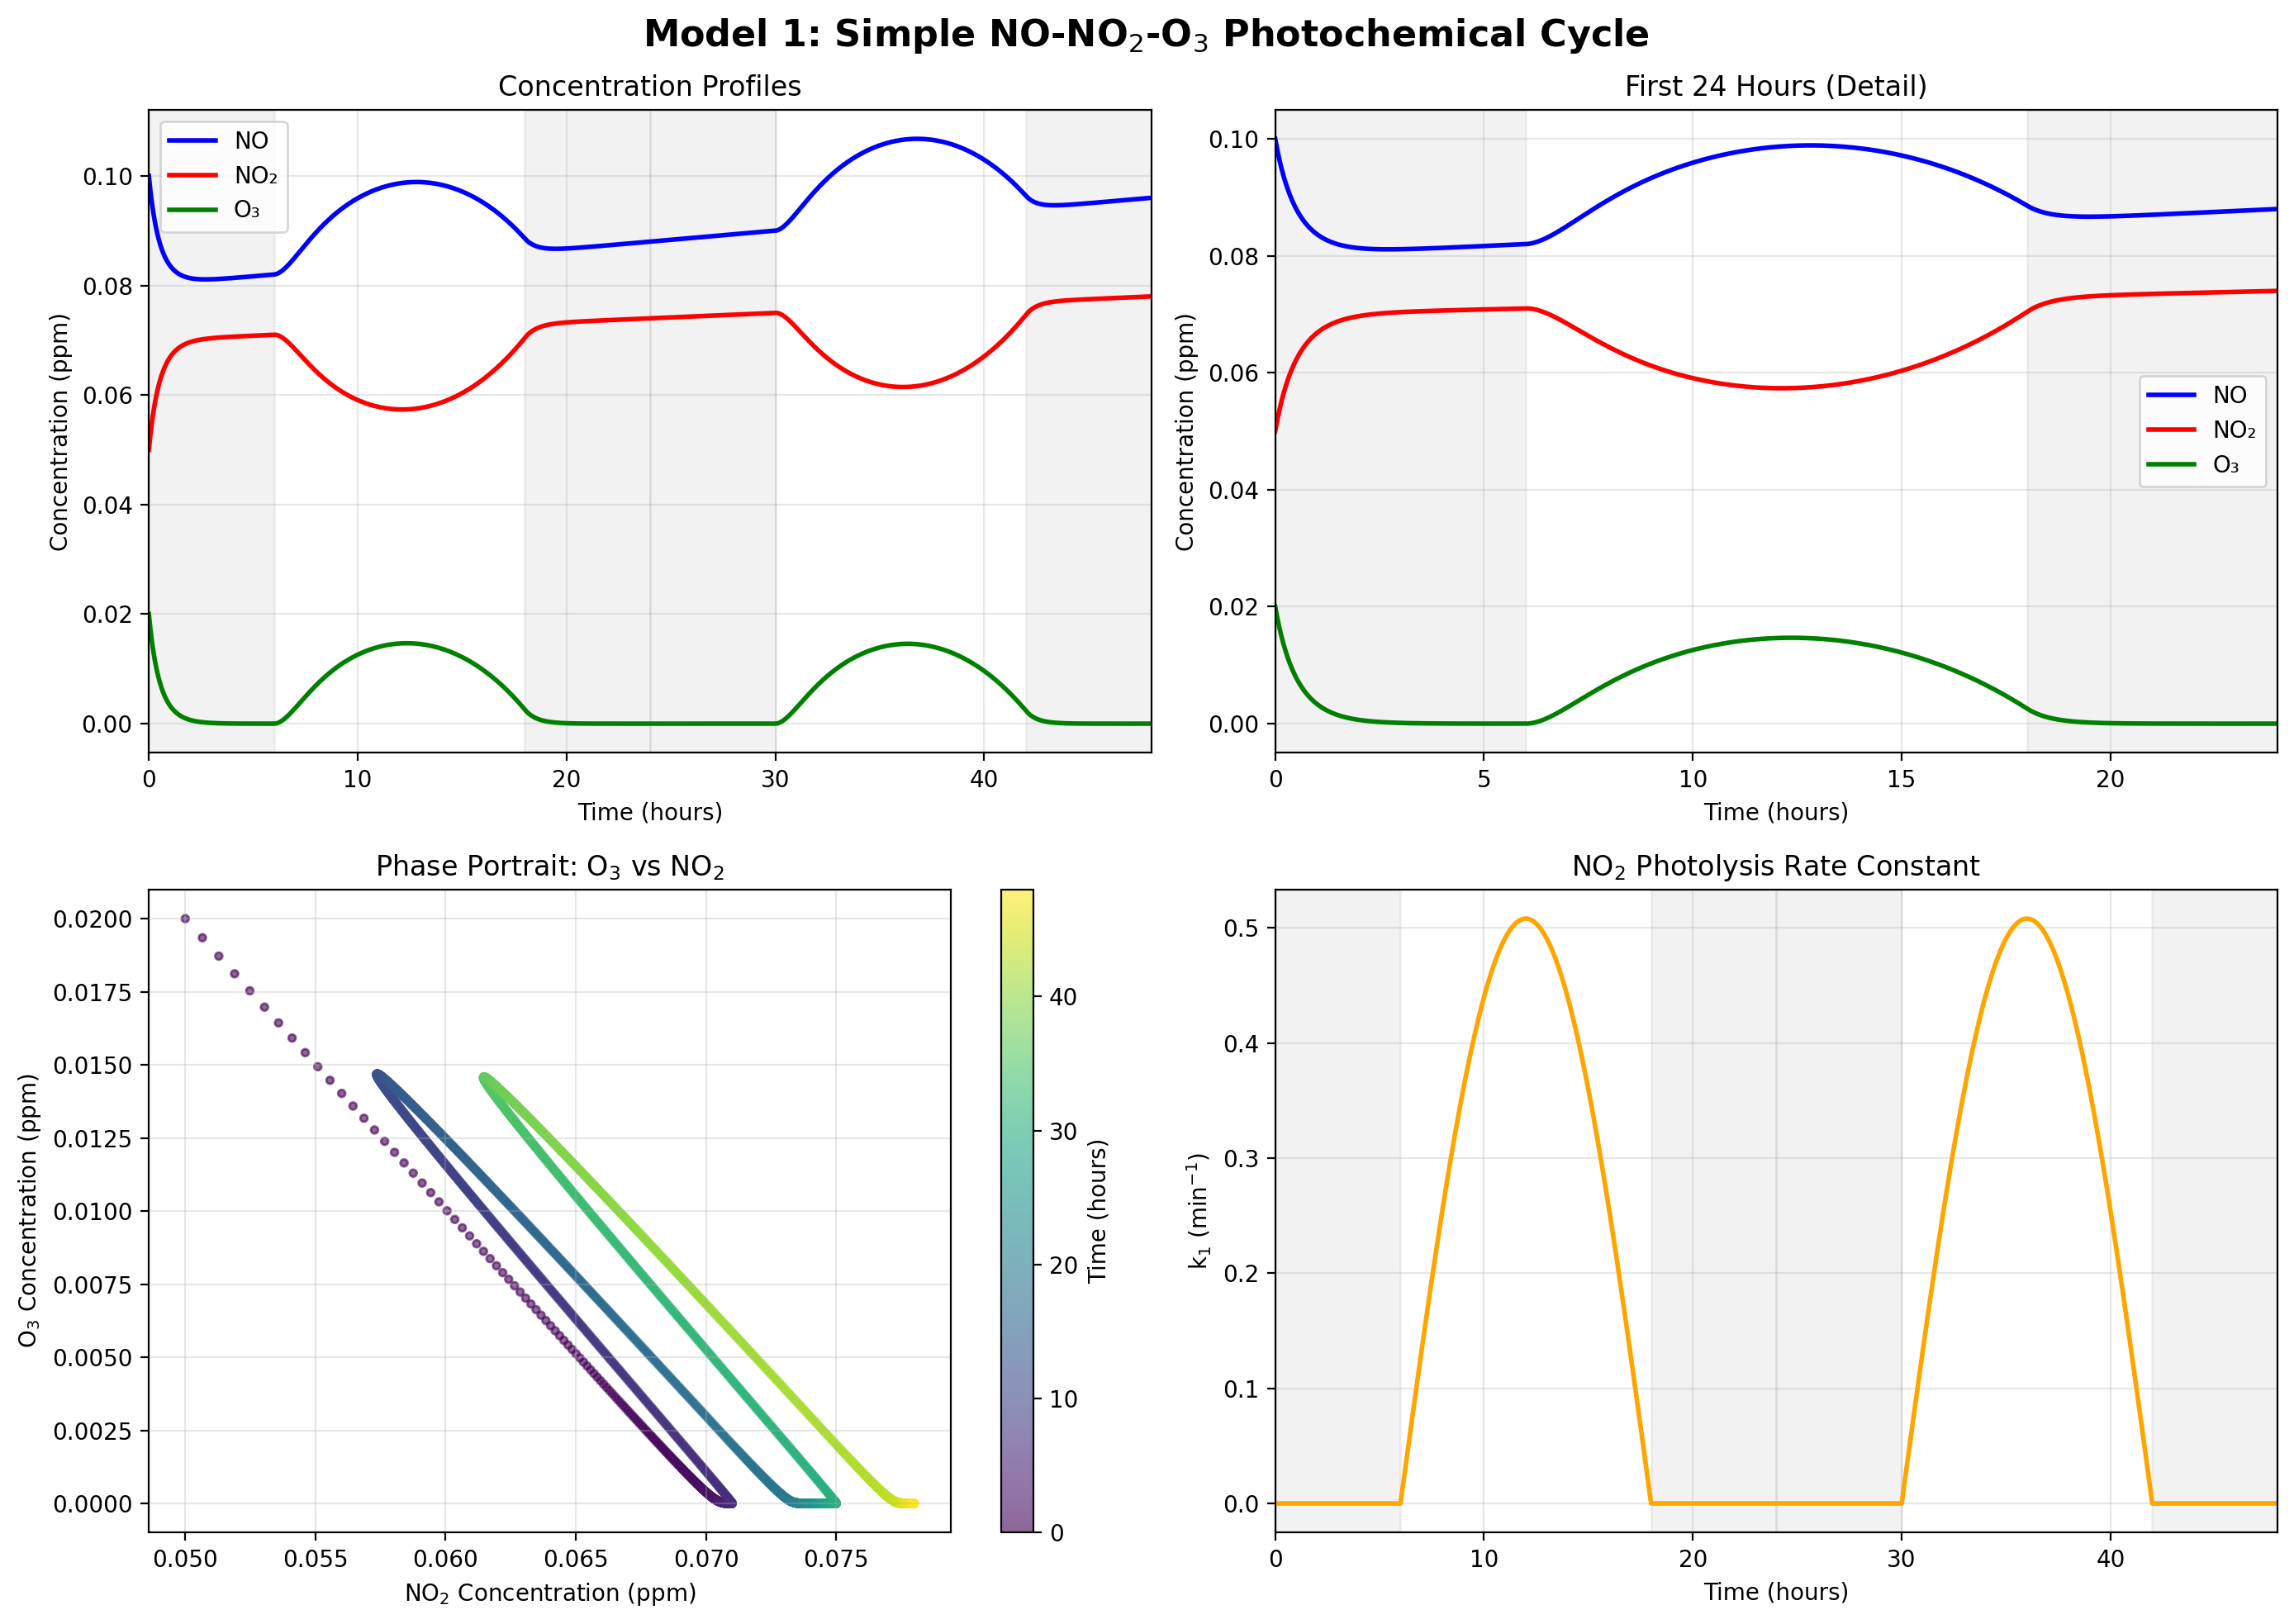


Running Model 2: Extended Chemistry with VOCs
Solving ODEs...
Peak O3: 0.3026 ppm at t = 32.8 hours
Peak OH: 4.16e-03 ppm at t = 37.2 hours
Peak HO2: 1.52e-03 ppm at t = 35.2 hours


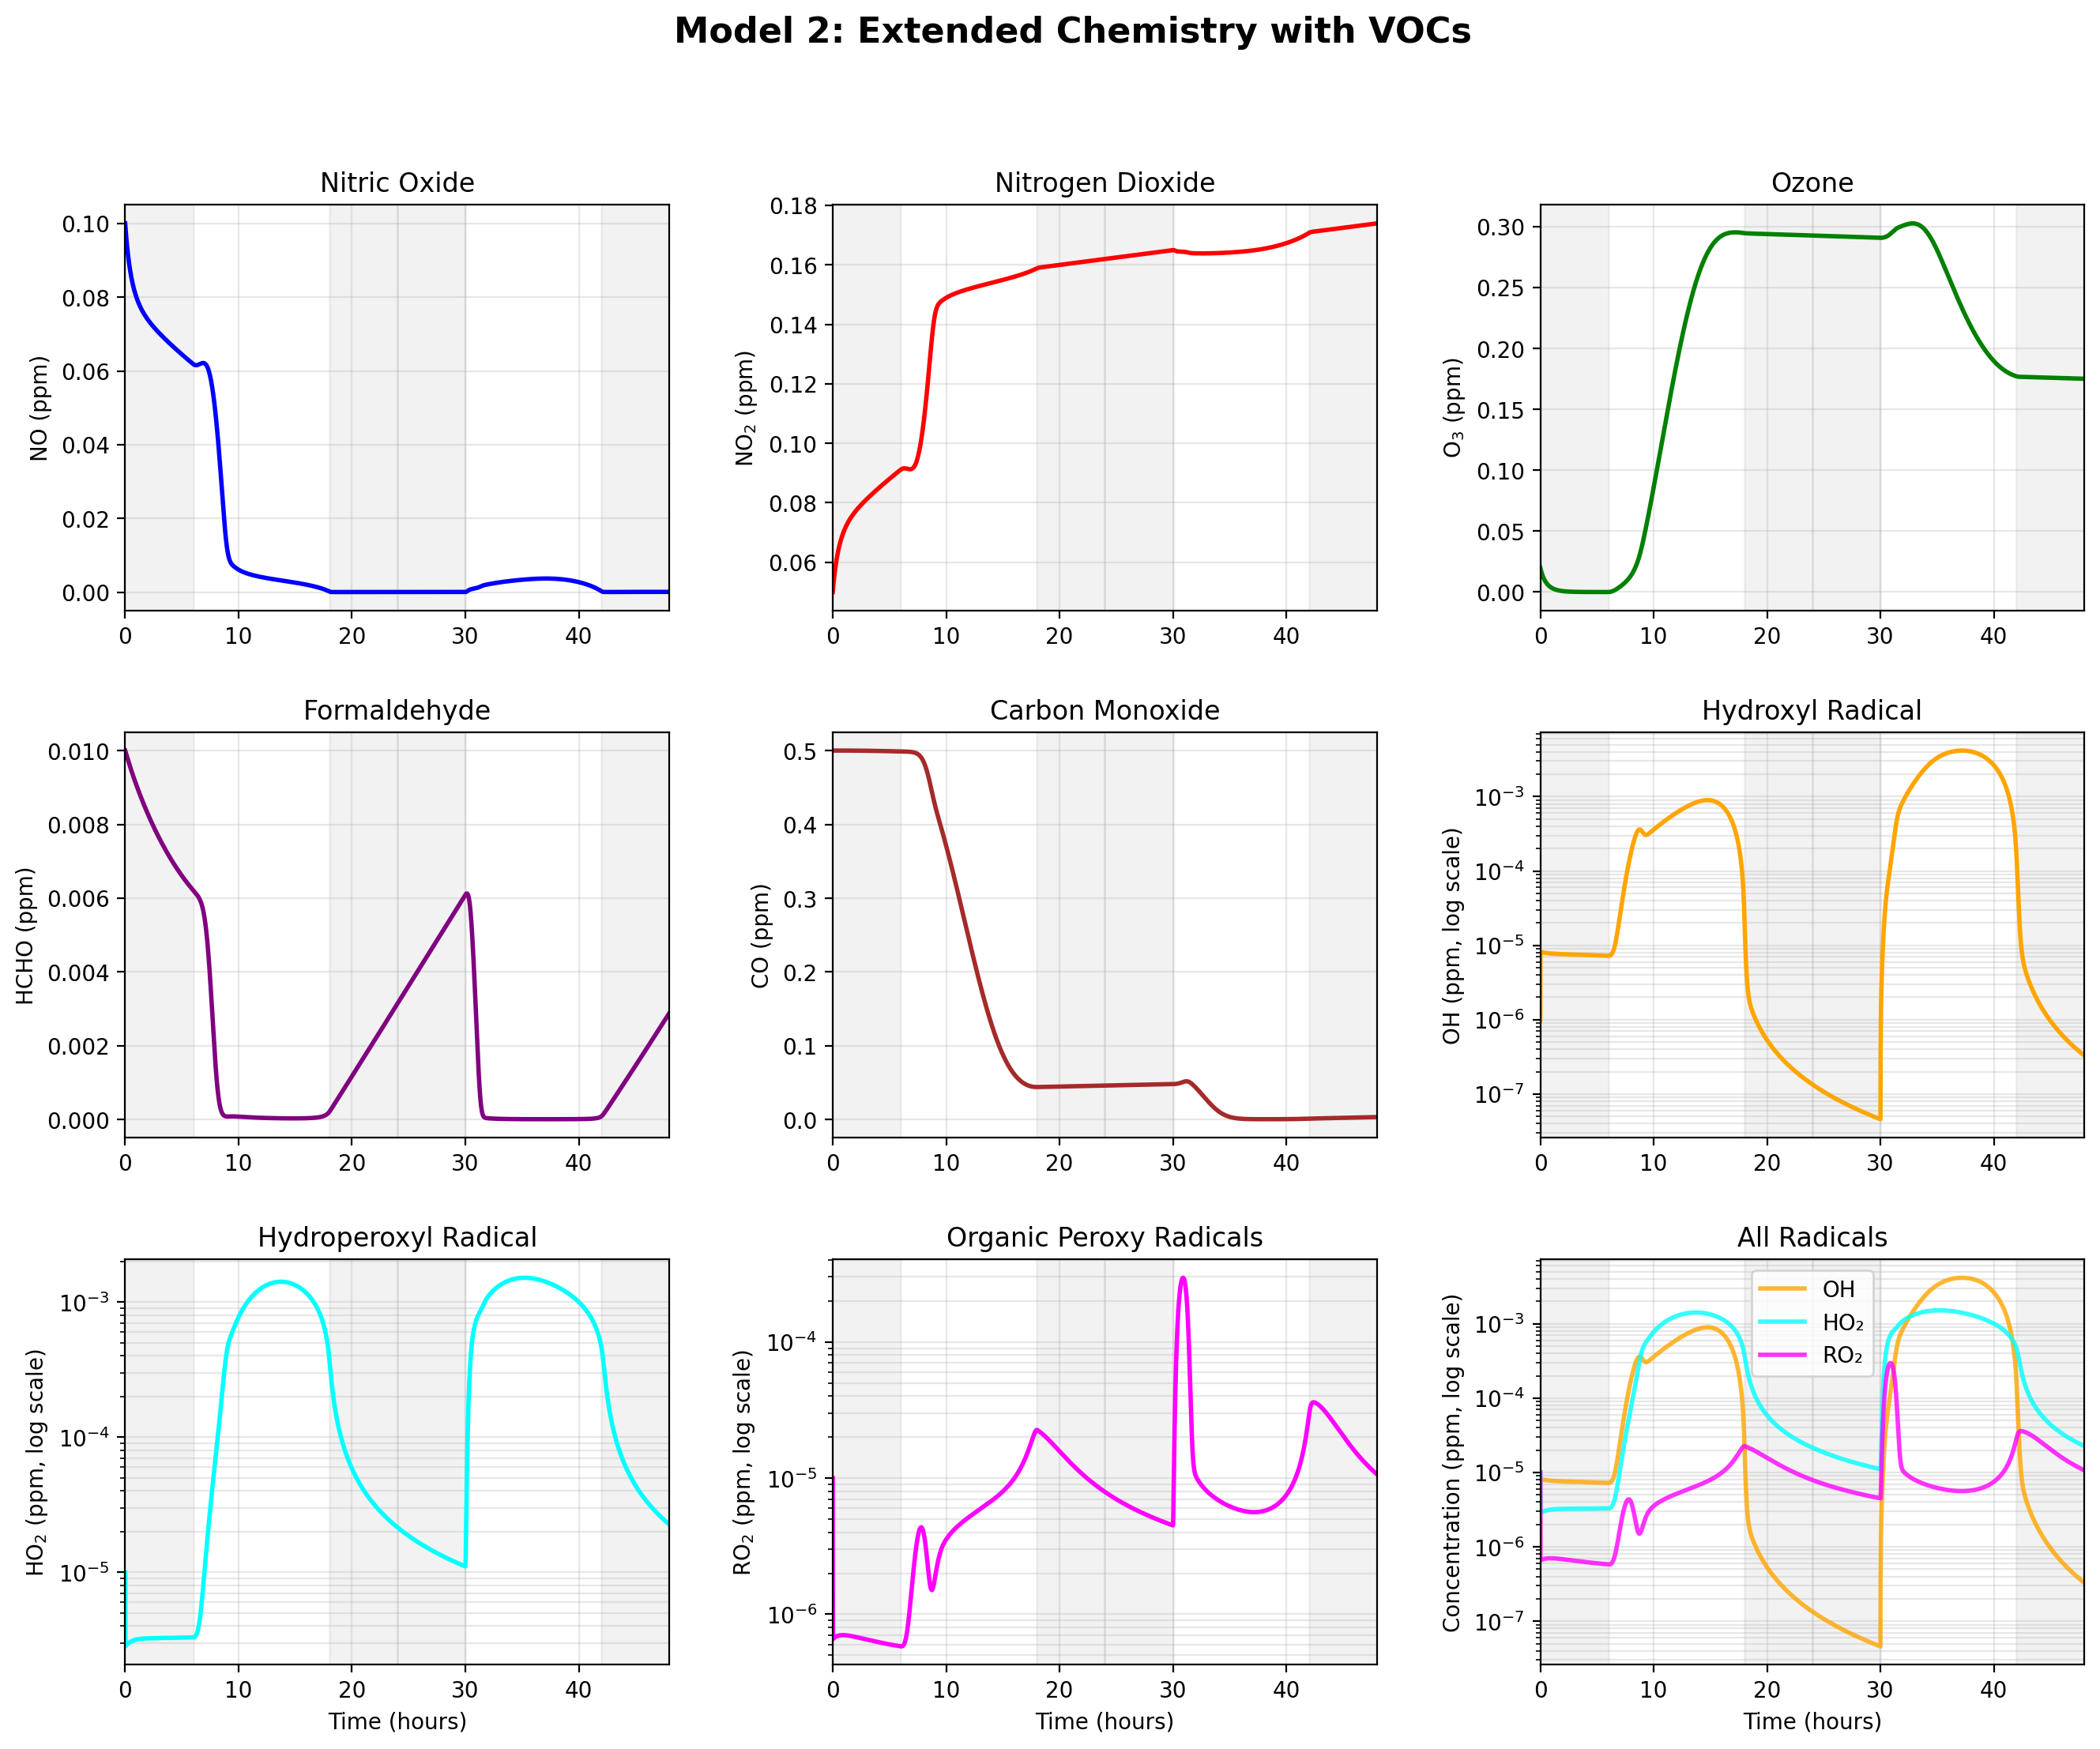


Creating Comparison Plots


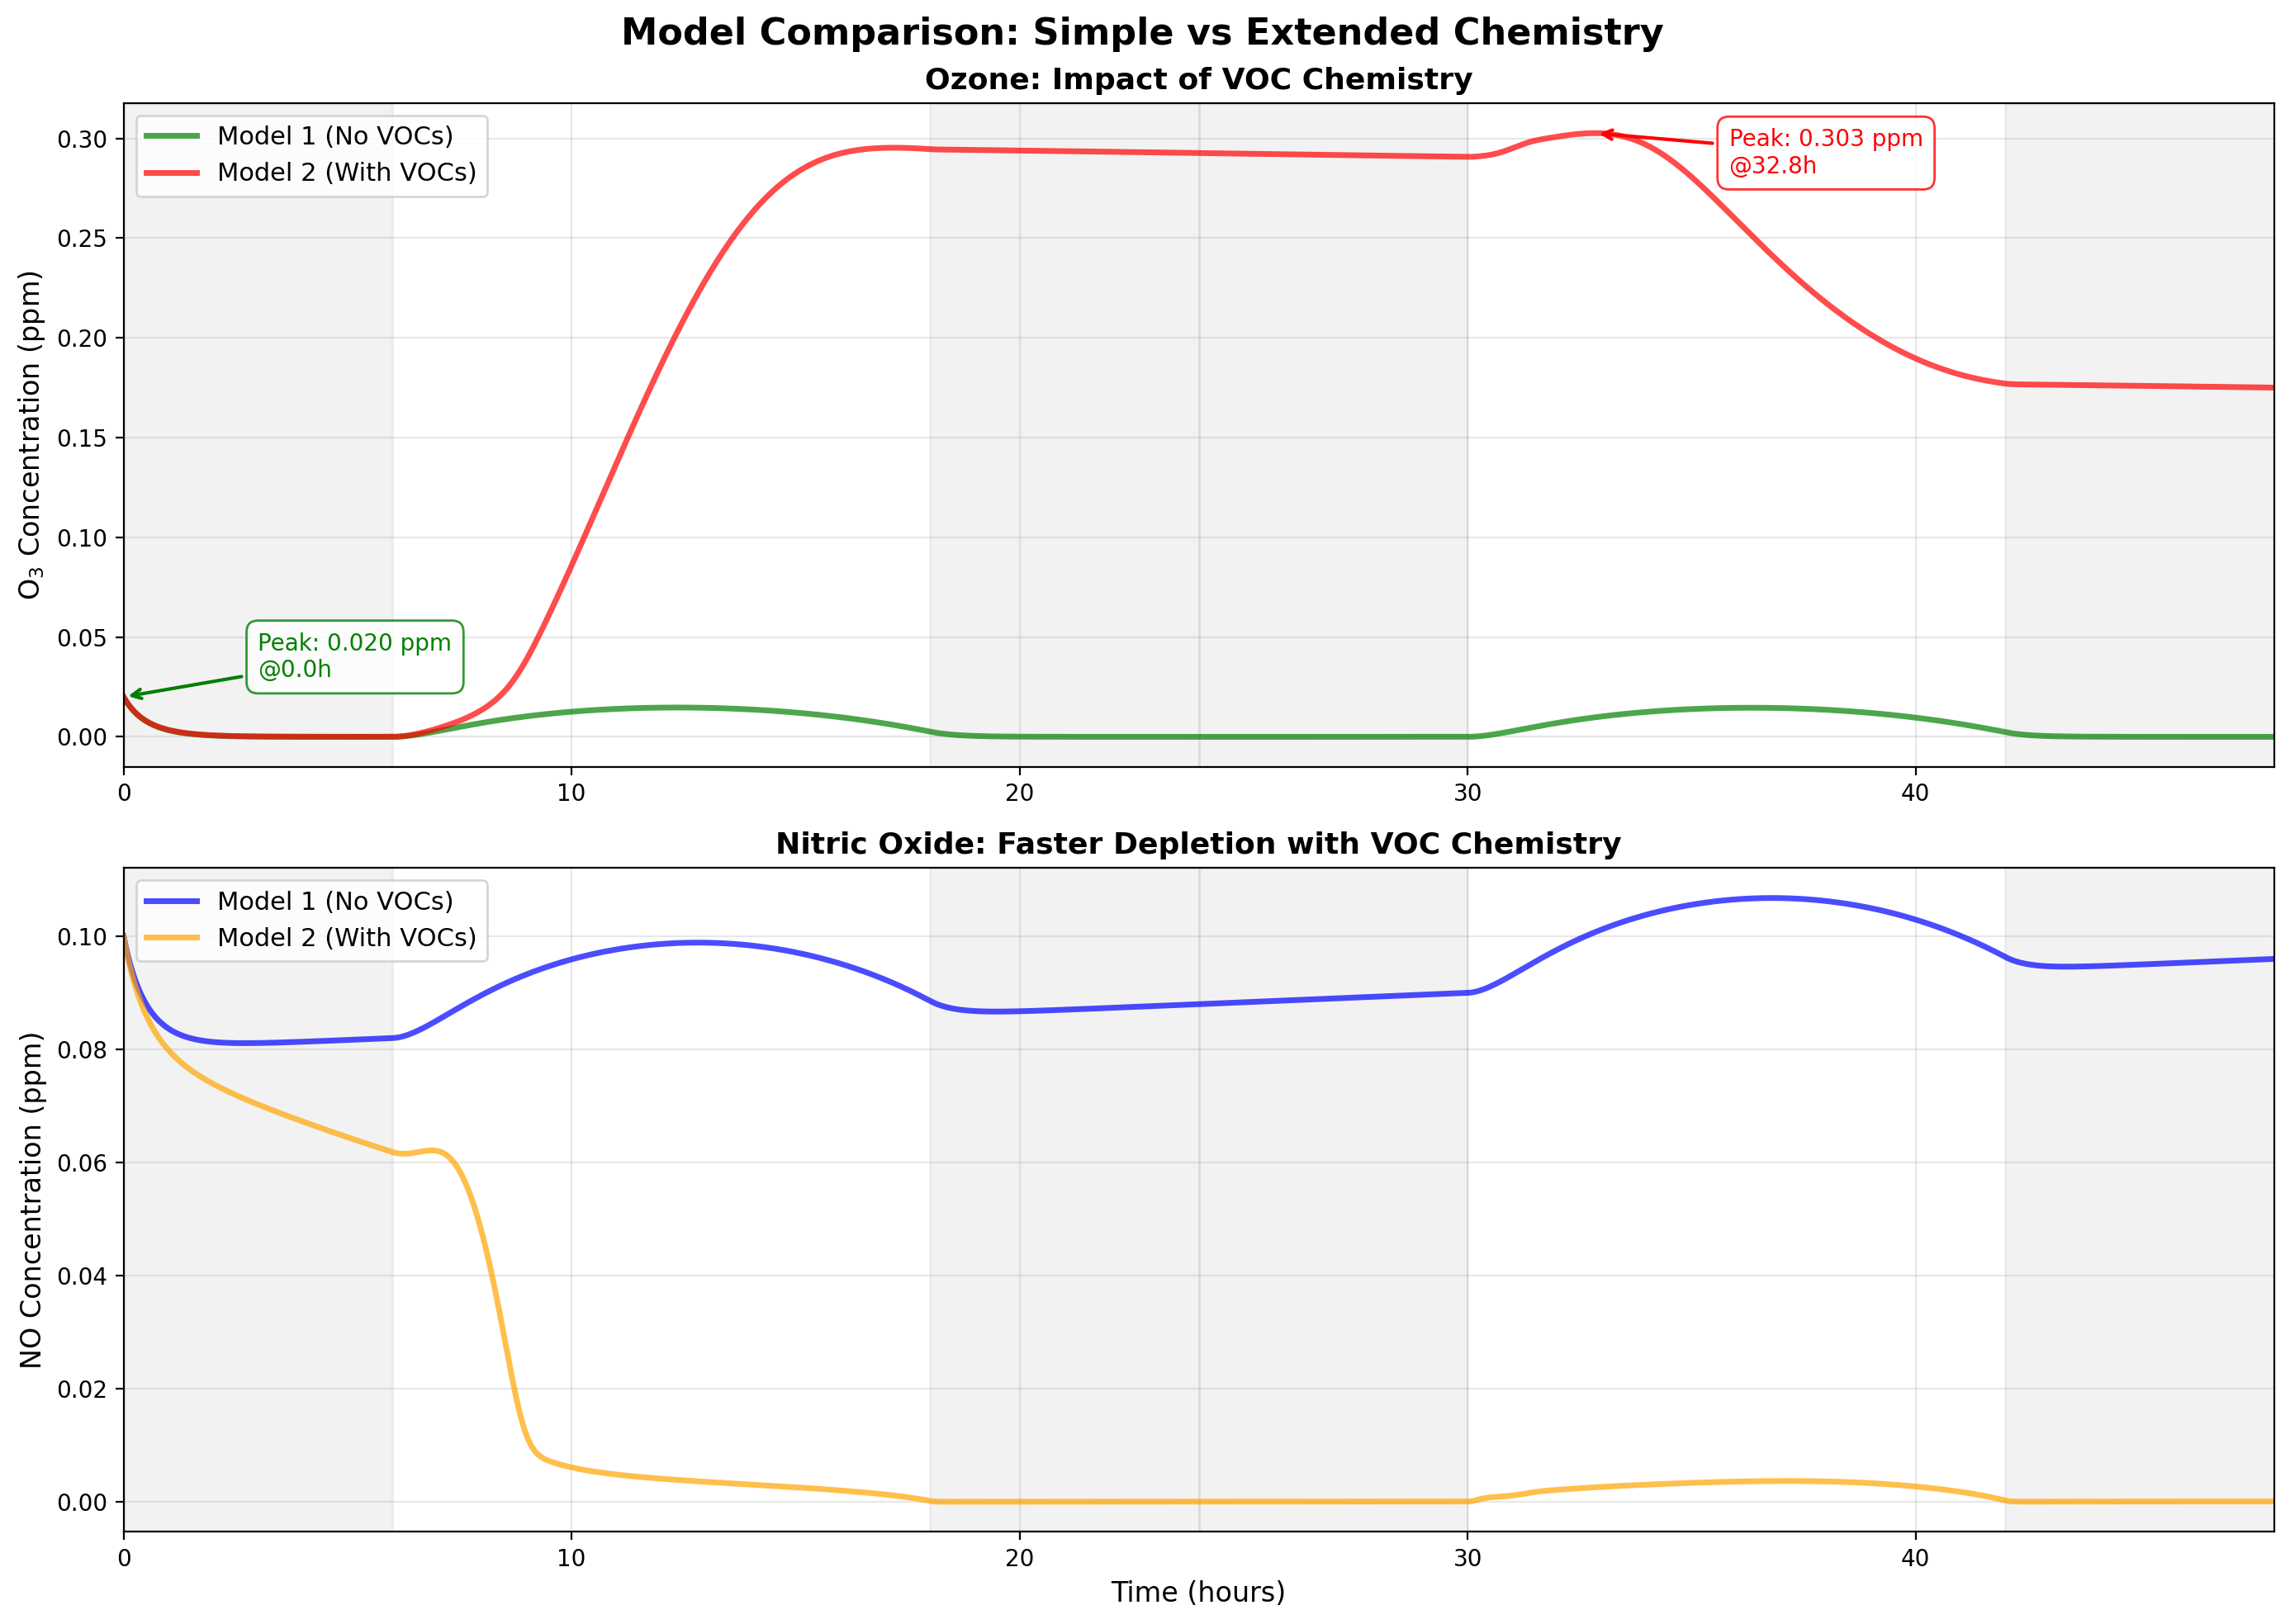


Quantitative Comparison:
------------------------------------------------------------
Metric                                   Model 1      Model 2     
------------------------------------------------------------
Peak O3 (ppm)                            0.0200       0.3026      
Peak O3 time (hours)                     0.0          32.8        
O3 enhancement factor                    -            15.13       
Min NO (ppm)                             0.0811       0.0000      
Final O3 (48h, ppm)                      0.0000       0.1751      
------------------------------------------------------------

Creating Detailed Comparison Figure
Solving Model 1...
Solving Model 2...


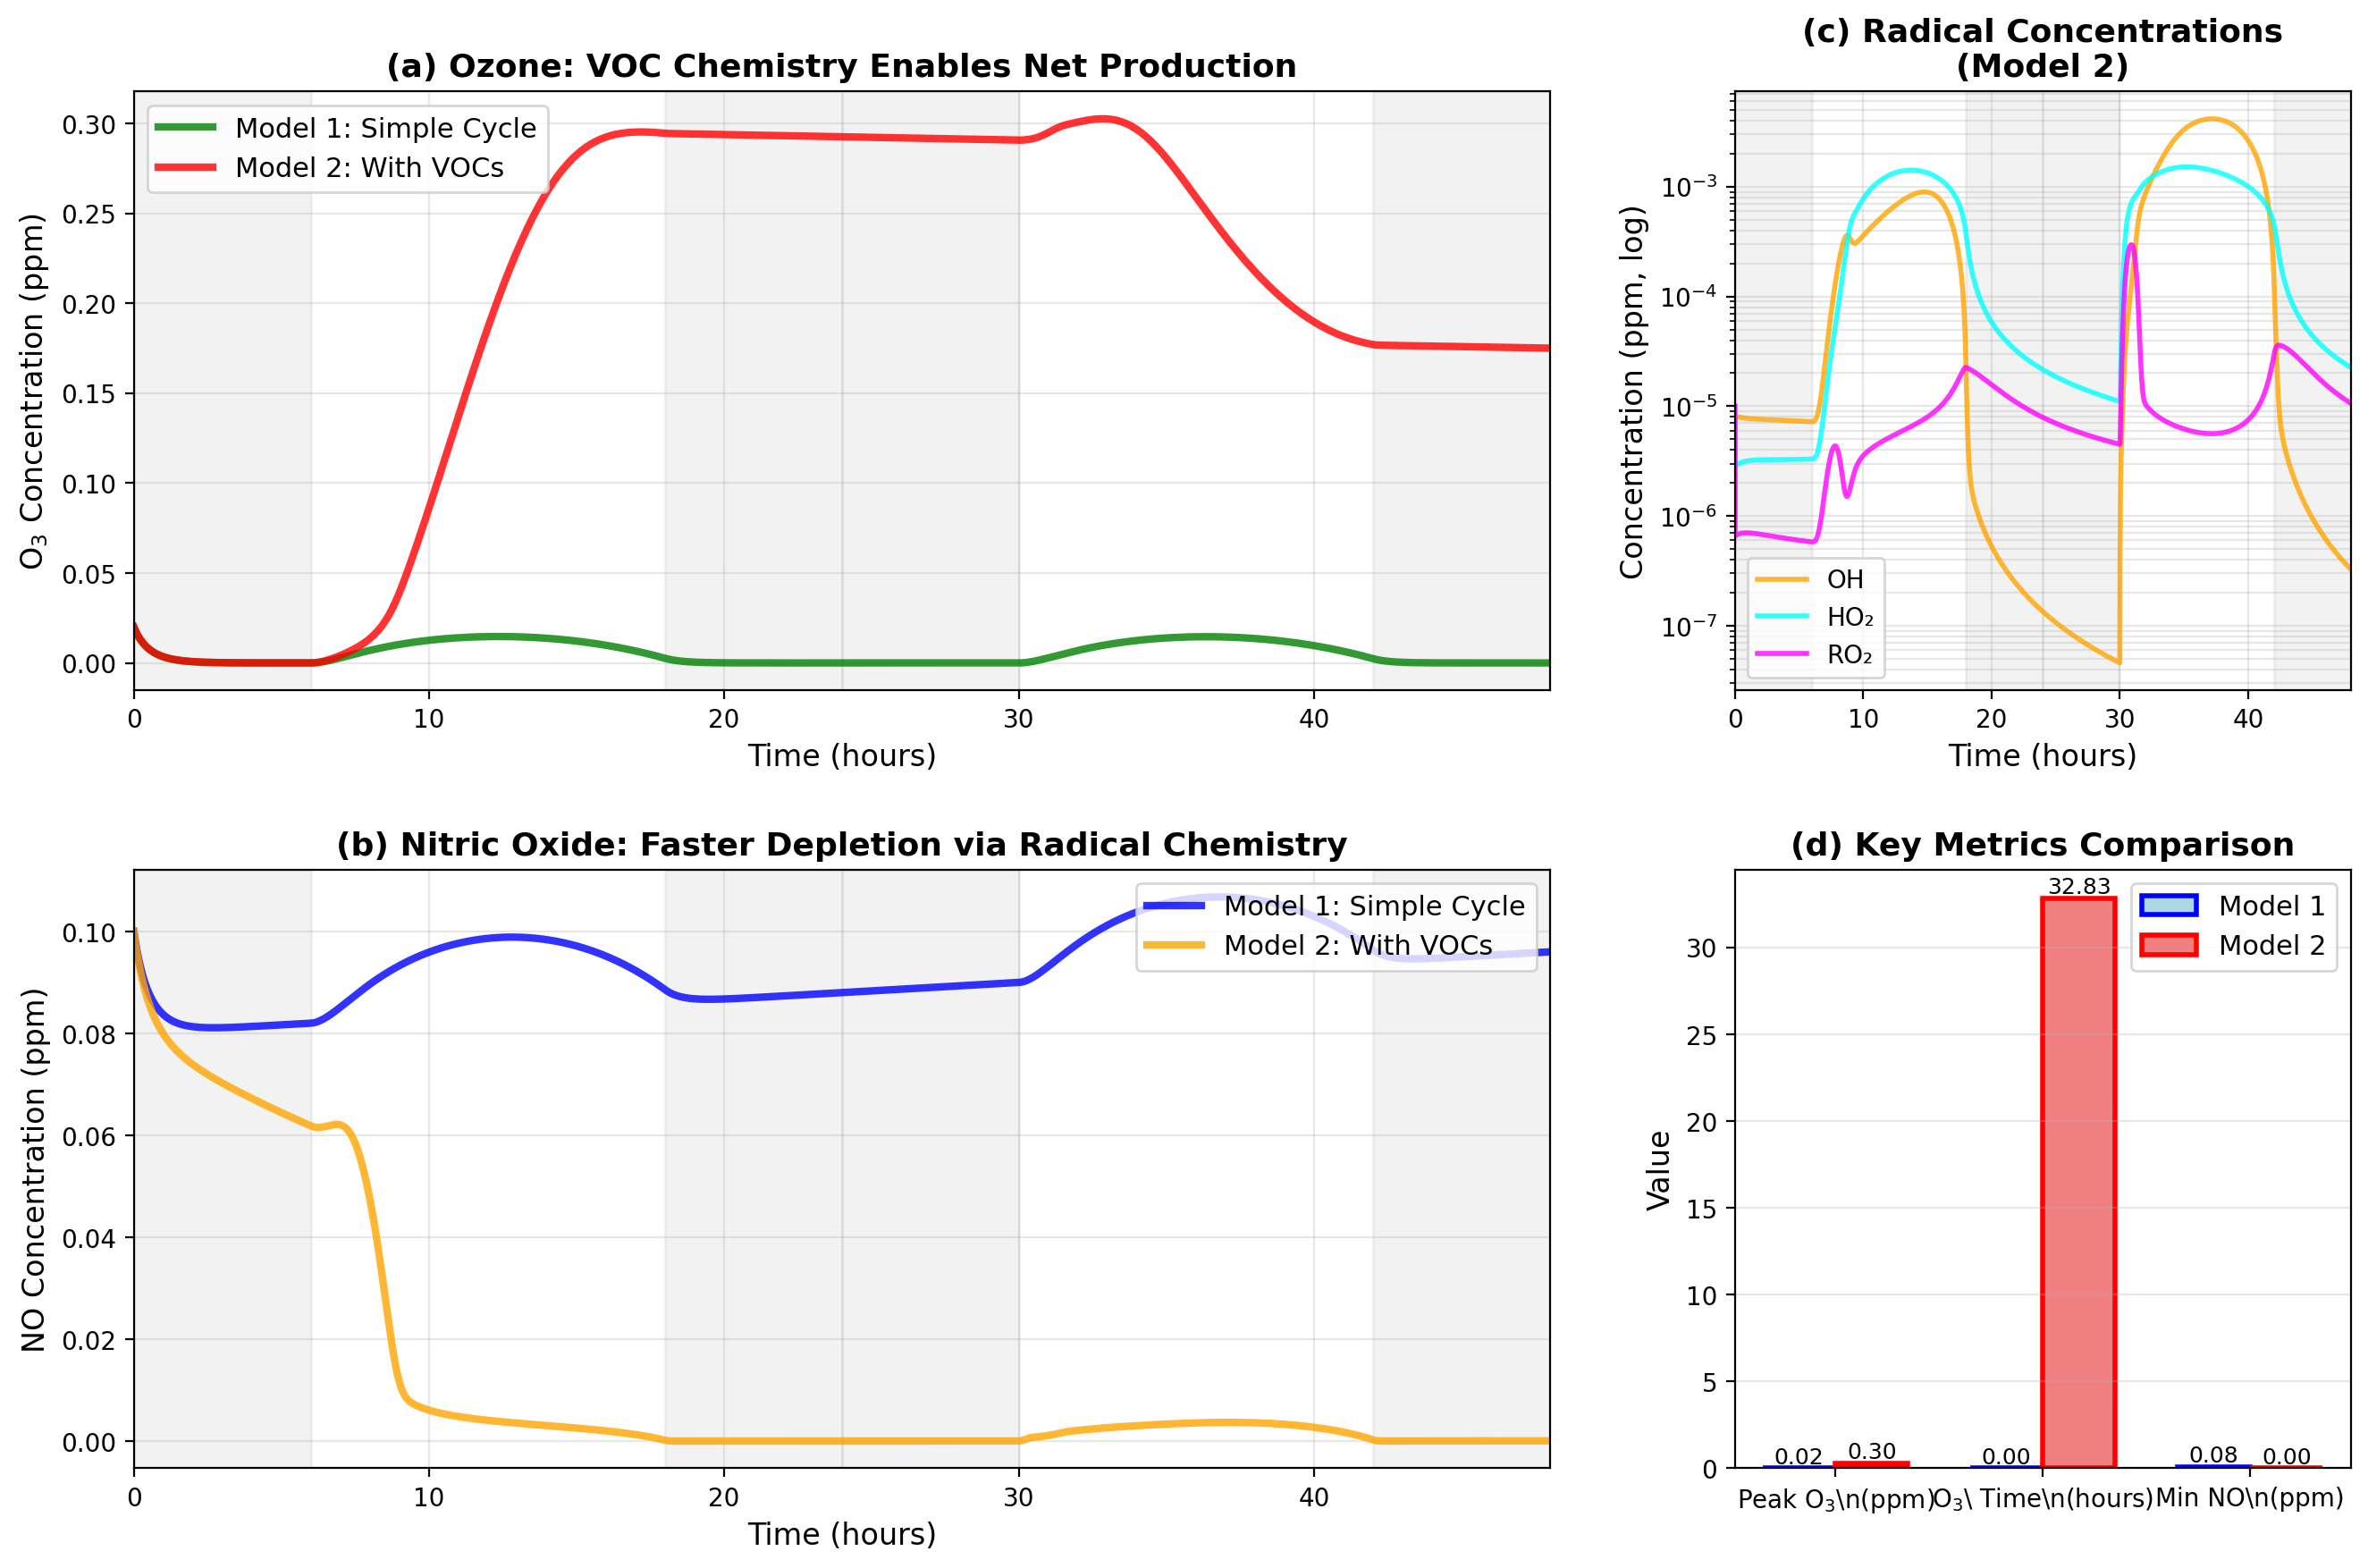


Performing Sensitivity Analysis: Emission Rates
Running sensitivity simulations...


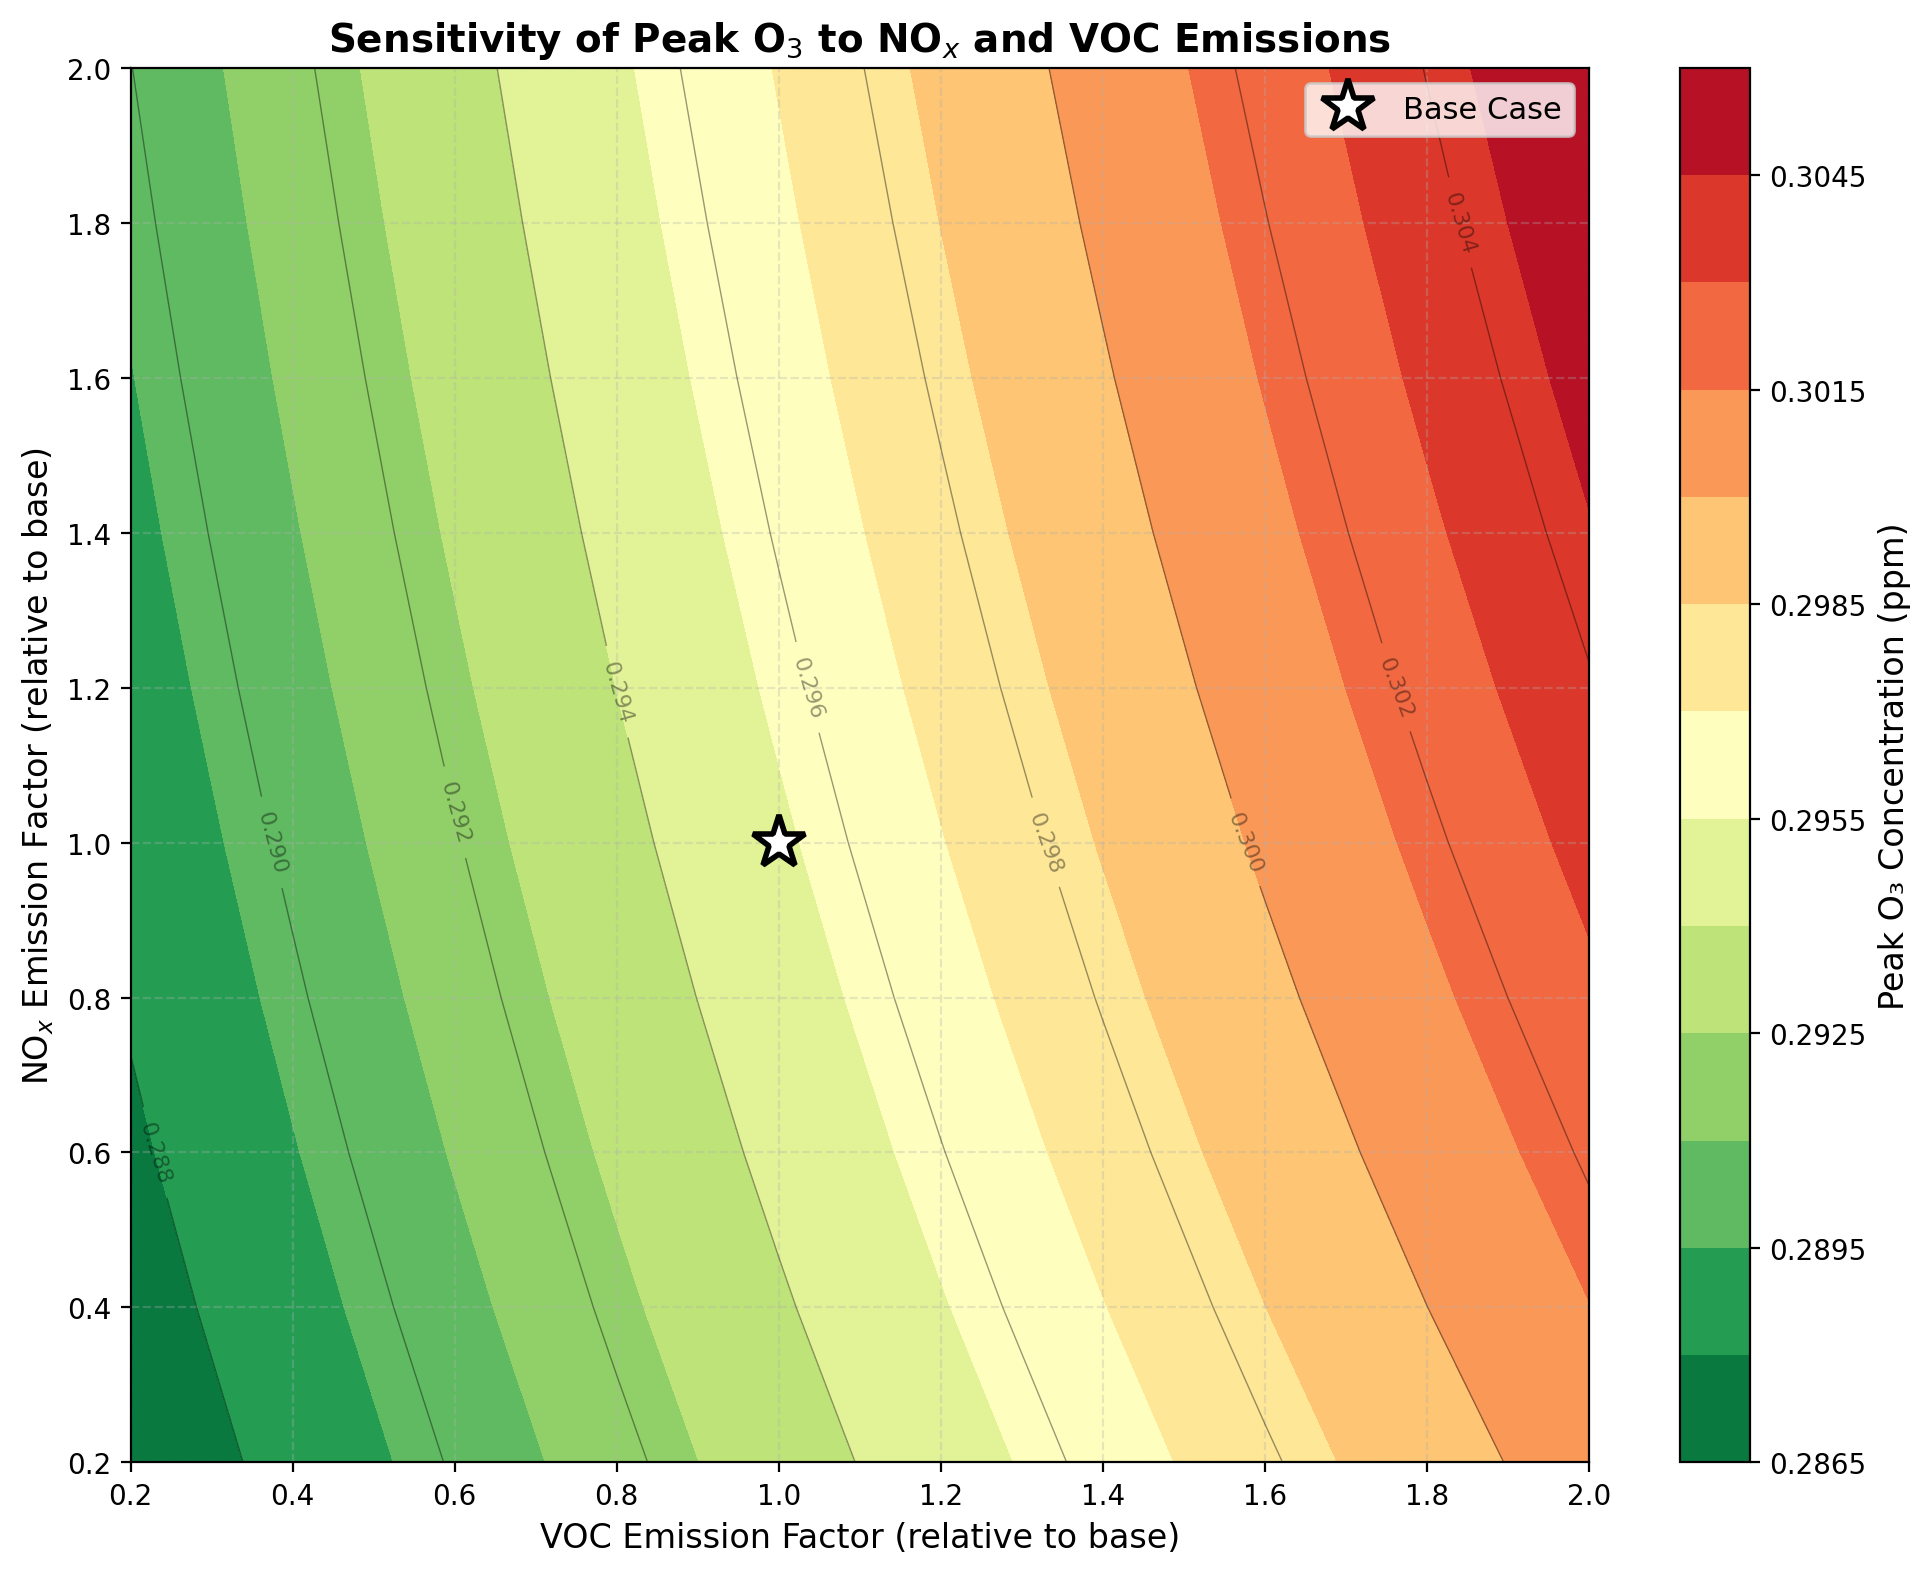


Regime Analysis:
------------------------------------------------------------
VOC-limited regime (High NOₓ, Low VOC): 0.2933 ppm
NOₓ-limited regime (Low NOₓ, High VOC): 0.3006 ppm
Balanced regime: 0.2974 ppm

Interpretation:
- In VOC-limited areas, reducing NOₓ may INCREASE O₃
- In NOₓ-limited areas, reducing NOₓ DECREASES O₃
- Urban cores often VOC-limited, suburbs NOₓ-limited

Performing Sensitivity Analysis: Temperature
Running temperature sensitivity simulations...


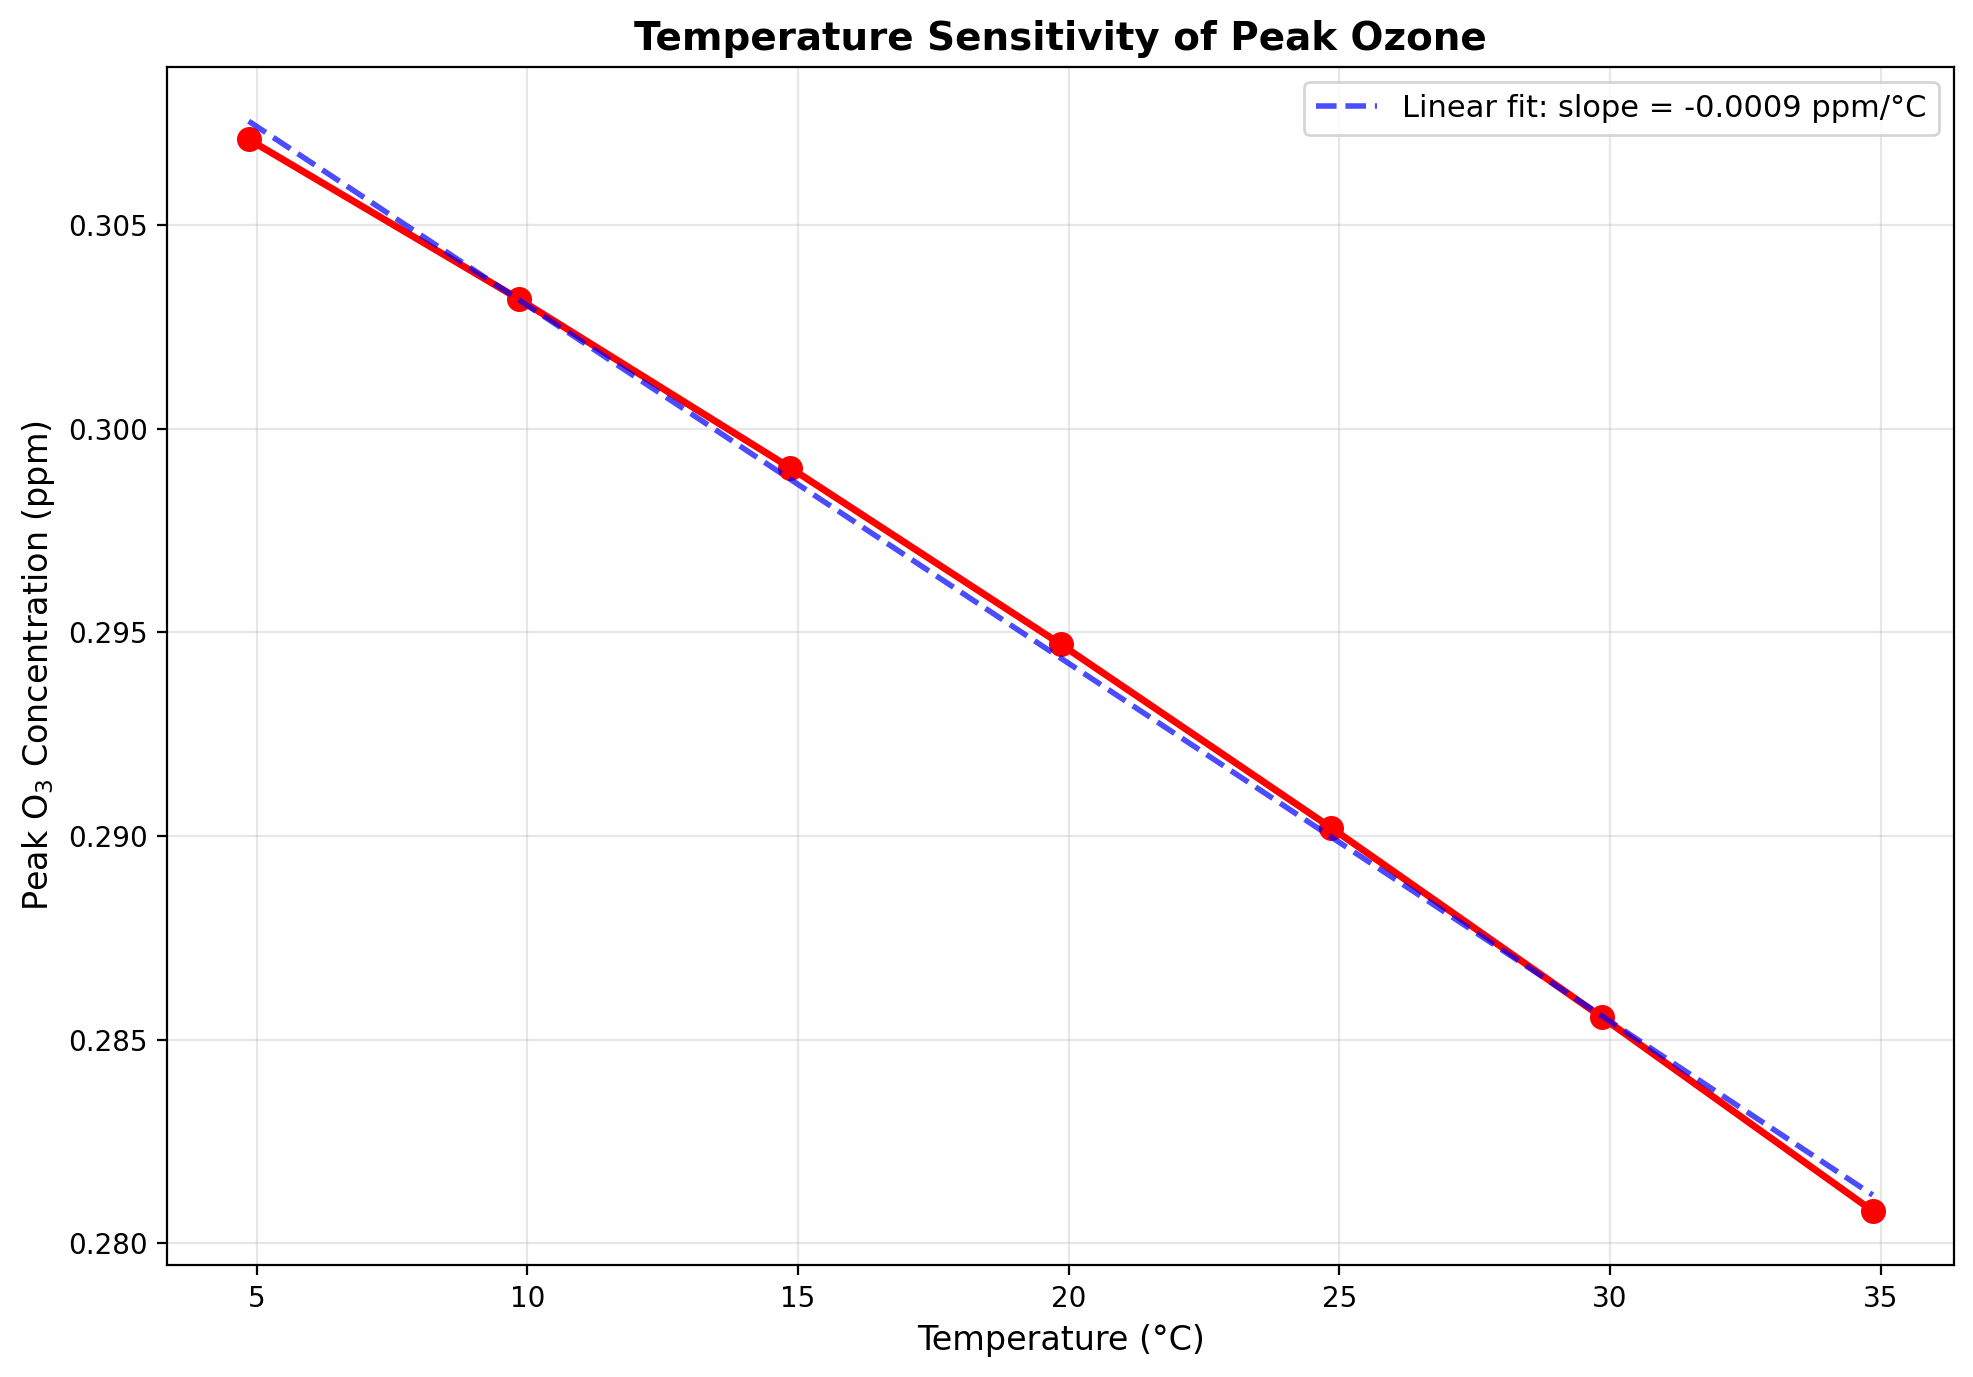


Temperature sensitivity:
O$_3$ change per 10 K: -2.9%
Peak O$_3$ at 5$^\circ$C: 0.3071 ppm
Peak O$_3$ at 35$^\circ$C: 0.2808 ppm
Ratio (35$^\circ$C/5$^\circ$C): 0.91

ALL SIMULATIONS COMPLETED SUCCESSFULLY

Generated files:
  - model1_concentrations.png
  - model2_concentrations.png
  - comparison_plot.png
  - detailed_comparison.png
  - sensitivity_emissions.png
  - sensitivity_temperature.png

Thank you for using this modeling framework!



In [10]:
# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def solar_intensity(t, k_max):
    """
    Calculate solar intensity factor based on time of day.
    
    Parameters:
    -----------
    t : float
        Time in hours (can be > 24 for multi-day simulations)
    k_max : float
        Maximum rate constant at solar noon
        
    Returns:
    --------
    float : Photolysis rate constant at time t
    """
    hour = t % 24
    if 6 <= hour <= 18:
        # Sinusoidal variation from sunrise (6h) to sunset (18h)
        return k_max * np.sin(np.pi * (hour - 6) / 12)
    return 0.0

def add_day_night_shading(ax, t_max):
    """Add shading to indicate day/night periods on plot."""
    for day in range(int(t_max // 24) + 1):
        # Night before sunrise (0-6h)
        ax.axvspan(day * 24, day * 24 + 6, alpha=0.1, color='gray', zorder=0)
        # Night after sunset (18-24h)
        ax.axvspan(day * 24 + 18, (day + 1) * 24, alpha=0.1, color='gray', zorder=0)

# ============================================================================
# MODEL 1: SIMPLE NO-NO2-O3 PHOTOCHEMICAL CYCLE
# ============================================================================

def model1_odes(y, t, params):
    """
    Model 1: Three-species photochemical cycle (NO, NO2, O3).
    
    Parameters:
    -----------
    y : array
        Concentrations [NO, NO2, O3] in ppm
    t : float
        Time in hours
    params : dict
        Dictionary containing rate constants and emissions
        
    Returns:
    --------
    list : Time derivatives [dNO/dt, dNO2/dt, dO3/dt]
    """
    NO, NO2, O3 = y
    
    # Time-dependent photolysis rate
    k1 = solar_intensity(t, params['k1_max'])
    
    # Extract other parameters
    k3 = params['k3']
    E_NO = params['E_NO']
    E_NO2 = params['E_NO2']
    
    # Reaction rates
    R1 = k1 * NO2                    # NO2 photolysis
    R3 = k3 * NO * O3               # NO + O3 -> NO2
    
    # Differential equations
    dNO_dt = R1 - R3 + E_NO
    dNO2_dt = -R1 + R3 + E_NO2
    dO3_dt = R1 - R3
    
    return [dNO_dt, dNO2_dt, dO3_dt]

def run_model1():
    """
    Run Model 1 simulation and create plots.
    """
    print("Running Model 1: Simple Photochemical Cycle")
    print("=" * 60)
    
    # Parameters
    params = {
        'k1_max': 0.508,      # min^-1 (maximum NO2 photolysis rate)
        'k3': 20.0,           # ppm^-1 min^-1 (NO + O3 reaction)
        'E_NO': 0.02 / 60,    # ppm/min (converted from ppm/h)
        'E_NO2': 0.01 / 60    # ppm/min
    }
    
    # Initial conditions (ppm)
    y0 = [
        0.100,  # NO
        0.050,  # NO2
        0.020   # O3
    ]
    
    # Time array (0 to 48 hours, 1-minute resolution)
    t = np.linspace(0, 48, 48 * 60 + 1)
    
    # Solve ODEs
    print("Solving ODEs...")
    solution = odeint(model1_odes, y0, t, args=(params,))
    
    NO = solution[:, 0]
    NO2 = solution[:, 1]
    O3 = solution[:, 2]
    
    print(f"Peak O3: {O3.max():.4f} ppm at t = {t[O3.argmax()]:.1f} hours")
    print(f"Peak NO2: {NO2.max():.4f} ppm at t = {t[NO2.argmax()]:.1f} hours")
    
    # Calculate photostationary state ratio
    midday_idx = np.argmin(np.abs(t - 12.0))
    if NO2[midday_idx] > 0:
        phi_simulated = (NO[midday_idx] * O3[midday_idx]) / NO2[midday_idx]
        phi_predicted = params['k1_max'] / params['k3']
        print(f"\nPhotostationary state check at noon (day 1):")
        print(fr"  Predicted $\phi$ = k1/k3 = {phi_predicted:.4f} ppm")
        print(fr"  Simulated $\phi$ = [NO][O3]/[NO2] = {phi_simulated:.4f} ppm")
        print(f"  Agreement: {(1 - abs(phi_simulated - phi_predicted)/phi_predicted)*100:.1f}%")
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(r'Model 1: Simple NO-NO$_2$-O$_3$ Photochemical Cycle', fontsize=16, fontweight='bold')
    
    # Plot 1: All concentrations
    ax1 = axes[0, 0]
    ax1.plot(t, NO, 'b-', label='NO', linewidth=2)
    ax1.plot(t, NO2, 'r-', label='NO₂', linewidth=2)
    ax1.plot(t, O3, 'g-', label='O₃', linewidth=2)
    add_day_night_shading(ax1, 48)
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Concentration (ppm)')
    ax1.set_title('Concentration Profiles')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 48)
    
    # Plot 2: Focus on first 24 hours
    ax2 = axes[0, 1]
    ax2.plot(t[:1440], NO[:1440], 'b-', label='NO', linewidth=2)
    ax2.plot(t[:1440], NO2[:1440], 'r-', label='NO₂', linewidth=2)
    ax2.plot(t[:1440], O3[:1440], 'g-', label='O₃', linewidth=2)
    add_day_night_shading(ax2, 24)
    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel('Concentration (ppm)')
    ax2.set_title('First 24 Hours (Detail)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 24)
    
    # Plot 3: Phase portrait (O3 vs NO2)
    ax3 = axes[1, 0]
    # Color code by time
    scatter = ax3.scatter(NO2, O3, c=t, cmap='viridis', s=10, alpha=0.6)
    ax3.set_xlabel(r'NO$_2$ Concentration (ppm)')
    ax3.set_ylabel(r'O$_3$ Concentration (ppm)')
    ax3.set_title(r'Phase Portrait: O$_3$ vs NO$_2$')
    ax3.grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('Time (hours)')
    
    # Plot 4: Photolysis rate
    ax4 = axes[1, 1]
    k1_values = np.array([solar_intensity(ti, params['k1_max']) for ti in t])
    ax4.plot(t, k1_values, 'orange', linewidth=2)
    add_day_night_shading(ax4, 48)
    ax4.set_xlabel('Time (hours)')
    ax4.set_ylabel(r'k$_1$ (min$^{-1}$)')
    ax4.set_title(r'NO$_2$ Photolysis Rate Constant')
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(0, 48)
    
    plt.tight_layout()
    # plt.savefig('model1_concentrations.png', dpi=300, bbox_inches='tight')
    # print("\nPlot saved: model1_concentrations.png")
    plt.show()
    
    return t, solution, params

# ============================================================================
# MODEL 2: EXTENDED CHEMISTRY WITH VOCs
# ============================================================================

def model2_odes(y, t, params):
    """
    Model 2: Eight-species system with VOC chemistry.
    Species: NO, NO2, O3, HCHO, CO, OH, HO2, RO2
    
    Parameters:
    -----------
    y : array
        Concentrations [NO, NO2, O3, HCHO, CO, OH, HO2, RO2] in ppm
    t : float
        Time in hours
    params : dict
        Dictionary containing rate constants and emissions
        
    Returns:
    --------
    list : Time derivatives for all 8 species
    """
    NO, NO2, O3, HCHO, CO, OH, HO2, RO2 = y
    
    # Time-dependent photolysis rates
    k1 = solar_intensity(t, params['k1_max'])
    k20 = solar_intensity(t, params['k20_max'])
    k21 = solar_intensity(t, params['k21_max'])
    
    # Extract chemical reaction rate constants
    k3 = params['k3']
    k15 = params['k15']
    k16 = params['k16']
    k19 = params['k19']
    k23 = params['k23']
    k47 = params['k47']
    k50 = params['k50']
    
    # Extract emissions
    E_NO = params['E_NO']
    E_NO2 = params['E_NO2']
    E_HCHO = params['E_HCHO']
    E_CO = params['E_CO']
    
    # Compute reaction rates
    R1 = k1 * NO2                           # NO2 + hv -> NO + O3
    R3 = k3 * NO * O3                       # NO + O3 -> NO2 + O2
    R15 = k15 * NO * HO2                    # HO2 + NO -> NO2 + OH
    R16 = k16 * NO * RO2                    # RO2 + NO -> NO2 + products
    R19 = k19 * CO * OH                     # CO + OH -> HO2 + CO2
    R20 = k20 * O3                          # O3 + hv -> 2OH
    R21 = k21 * HCHO                        # HCHO + hv -> 2HO2 + CO
    R23 = k23 * HCHO * OH                   # HCHO + OH -> HO2 + CO
    R47 = k47 * O3 * OH                     # O3 + OH -> HO2 + O2
    R50 = k50 * HO2 * HO2                   # HO2 + HO2 -> H2O2 + O2
    
    # Differential equations
    dNO_dt = R1 - R3 - R15 - R16 + E_NO
    
    dNO2_dt = -R1 + R3 + R15 + R16 + E_NO2
    
    dO3_dt = R1 - R3 - R20 - R47
    
    dHCHO_dt = -R21 - R23 + E_HCHO
    
    dCO_dt = R21 + R23 - R19 + E_CO
    
    dOH_dt = 2*R20 - R19 - R23 + R15 - R47
    
    dHO2_dt = 2*R21 + R23 + R19 - R15 - 2*R50 + R47
    
    # Simplified RO2 production from HCHO oxidation
    dRO2_dt = 0.5 * R23 - R16
    
    return [dNO_dt, dNO2_dt, dO3_dt, dHCHO_dt, dCO_dt, 
            dOH_dt, dHO2_dt, dRO2_dt]

def run_model2():
    """
    Run Model 2 simulation and create plots.
    """
    print("\n" + "=" * 60)
    print("Running Model 2: Extended Chemistry with VOCs")
    print("=" * 60)
    
    # Parameters
    params = {
        # Photochemical rate constants (maxima at noon)
        'k1_max': 0.508,          # min^-1
        'k20_max': 0.0328,        # min^-1
        'k21_max': 0.00284,       # min^-1
        
        # Chemical rate constants
        'k3': 20.0,               # ppm^-1 min^-1
        'k15': 12000.0,           # ppm^-1 min^-1
        'k16': 12000.0,           # ppm^-1 min^-1
        'k19': 440.0,             # ppm^-1 min^-1
        'k23': 19200.0,           # ppm^-1 min^-1
        'k47': 78.0,              # ppm^-1 min^-1
        'k50': 3700.0,            # ppm^-1 min^-1
        
        # Emissions (ppm/min)
        'E_NO': 0.02 / 60,
        'E_NO2': 0.01 / 60,
        'E_HCHO': 0.03 / 60,
        'E_CO': 0.02 / 60
    }
    
    # Initial conditions (ppm)
    y0 = [
        0.100,      # NO
        0.050,      # NO2
        0.020,      # O3
        0.010,      # HCHO
        0.500,      # CO
        1.0e-6,     # OH
        1.0e-5,     # HO2
        1.0e-5      # RO2
    ]
    
    # Time array (0 to 48 hours)
    t = np.linspace(0, 48, 48 * 60 + 1)
    
    # Solve ODEs
    print("Solving ODEs...")
    solution = odeint(model2_odes, y0, t, args=(params,), rtol=1e-6, atol=1e-9)
    
    NO = solution[:, 0]
    NO2 = solution[:, 1]
    O3 = solution[:, 2]
    HCHO = solution[:, 3]
    CO = solution[:, 4]
    OH = solution[:, 5]
    HO2 = solution[:, 6]
    RO2 = solution[:, 7]
    
    print(f"Peak O3: {O3.max():.4f} ppm at t = {t[O3.argmax()]:.1f} hours")
    print(f"Peak OH: {OH.max():.2e} ppm at t = {t[OH.argmax()]:.1f} hours")
    print(f"Peak HO2: {HO2.max():.2e} ppm at t = {t[HO2.argmax()]:.1f} hours")
    
    # Create comprehensive plots
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle('Model 2: Extended Chemistry with VOCs', fontsize=16, fontweight='bold')
    
    # Define grid
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Plot 1: NO
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(t, NO, 'b-', linewidth=2)
    add_day_night_shading(ax1, 48)
    ax1.set_ylabel('NO (ppm)')
    ax1.set_title('Nitric Oxide')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 48)
    
    # Plot 2: NO2
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(t, NO2, 'r-', linewidth=2)
    add_day_night_shading(ax2, 48)
    ax2.set_ylabel(r'NO$_2$ (ppm)')
    ax2.set_title('Nitrogen Dioxide')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 48)
    
    # Plot 3: O3
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(t, O3, 'g-', linewidth=2)
    add_day_night_shading(ax3, 48)
    ax3.set_ylabel(r'O$_3$ (ppm)')
    ax3.set_title('Ozone')
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(0, 48)
    
    # Plot 4: HCHO
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.plot(t, HCHO, 'purple', linewidth=2)
    add_day_night_shading(ax4, 48)
    ax4.set_ylabel('HCHO (ppm)')
    ax4.set_title('Formaldehyde')
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(0, 48)
    
    # Plot 5: CO
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.plot(t, CO, 'brown', linewidth=2)
    add_day_night_shading(ax5, 48)
    ax5.set_ylabel('CO (ppm)')
    ax5.set_title('Carbon Monoxide')
    ax5.grid(True, alpha=0.3)
    ax5.set_xlim(0, 48)
    
    # Plot 6: OH (log scale)
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.semilogy(t, OH, 'orange', linewidth=2)
    add_day_night_shading(ax6, 48)
    ax6.set_ylabel('OH (ppm, log scale)')
    ax6.set_title('Hydroxyl Radical')
    ax6.grid(True, alpha=0.3, which='both')
    ax6.set_xlim(0, 48)
    
    # Plot 7: HO2 (log scale)
    ax7 = fig.add_subplot(gs[2, 0])
    ax7.semilogy(t, HO2, 'cyan', linewidth=2)
    add_day_night_shading(ax7, 48)
    ax7.set_xlabel('Time (hours)')
    ax7.set_ylabel(r'HO$_2$ (ppm, log scale)')
    ax7.set_title('Hydroperoxyl Radical')
    ax7.grid(True, alpha=0.3, which='both')
    ax7.set_xlim(0, 48)
    
    # Plot 8: RO2 (log scale)
    ax8 = fig.add_subplot(gs[2, 1])
    ax8.semilogy(t, RO2, 'magenta', linewidth=2)
    add_day_night_shading(ax8, 48)
    ax8.set_xlabel('Time (hours)')
    ax8.set_ylabel(r'RO$_2$ (ppm, log scale)')
    ax8.set_title('Organic Peroxy Radicals')
    ax8.grid(True, alpha=0.3, which='both')
    ax8.set_xlim(0, 48)
    
    # Plot 9: All radicals together
    ax9 = fig.add_subplot(gs[2, 2])
    ax9.semilogy(t, OH, 'orange', linewidth=2, label='OH', alpha=0.8)
    ax9.semilogy(t, HO2, 'cyan', linewidth=2, label='HO₂', alpha=0.8)
    ax9.semilogy(t, RO2, 'magenta', linewidth=2, label='RO₂', alpha=0.8)
    add_day_night_shading(ax9, 48)
    ax9.set_xlabel('Time (hours)')
    ax9.set_ylabel('Concentration (ppm, log scale)')
    ax9.set_title('All Radicals')
    ax9.legend()
    ax9.grid(True, alpha=0.3, which='both')
    ax9.set_xlim(0, 48)
    
    # plt.savefig('model2_concentrations.png', dpi=300, bbox_inches='tight')
    # print("Plot saved: model2_concentrations.png")
    plt.show()
    
    return t, solution, params

# ============================================================================
# COMPARISON PLOTS
# ============================================================================

def create_comparison_plots(t1, sol1, params1, t2, sol2, params2):
    """
    Create side-by-side comparison plots of Model 1 and Model 2.
    """
    print("\n" + "=" * 60)
    print("Creating Comparison Plots")
    print("=" * 60)
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    fig.suptitle('Model Comparison: Simple vs Extended Chemistry', 
                 fontsize=16, fontweight='bold')
    
    # Plot 1: O3 comparison
    ax1 = axes[0]
    ax1.plot(t1, sol1[:, 2], 'g-', linewidth=2.5, label='Model 1 (No VOCs)', alpha=0.7)
    ax1.plot(t2, sol2[:, 2], 'r-', linewidth=2.5, label='Model 2 (With VOCs)', alpha=0.7)
    add_day_night_shading(ax1, 48)
    ax1.set_ylabel(r'O$_3$ Concentration (ppm)', fontsize=12)
    ax1.set_title('Ozone: Impact of VOC Chemistry', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 48)
    
    # Add annotations for peak values
    peak_o3_model1 = sol1[:, 2].max()
    peak_o3_model2 = sol2[:, 2].max()
    peak_time_model1 = t1[sol1[:, 2].argmax()]
    peak_time_model2 = t2[sol2[:, 2].argmax()]
    
    ax1.annotate(f'Peak: {peak_o3_model1:.3f} ppm\n@{peak_time_model1:.1f}h',
                xy=(peak_time_model1, peak_o3_model1),
                xytext=(peak_time_model1 + 3, peak_o3_model1 + 0.01),
                arrowprops=dict(arrowstyle='->', color='green', lw=1.5),
                fontsize=10, color='green',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='green', alpha=0.8))
    
    ax1.annotate(f'Peak: {peak_o3_model2:.3f} ppm\n@{peak_time_model2:.1f}h',
                xy=(peak_time_model2, peak_o3_model2),
                xytext=(peak_time_model2 + 3, peak_o3_model2 - 0.02),
                arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                fontsize=10, color='red',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='red', alpha=0.8))
    
    # Plot 2: NO comparison
    ax2 = axes[1]
    ax2.plot(t1, sol1[:, 0], 'b-', linewidth=2.5, label='Model 1 (No VOCs)', alpha=0.7)
    ax2.plot(t2, sol2[:, 0], 'orange', linewidth=2.5, label='Model 2 (With VOCs)', alpha=0.7)
    add_day_night_shading(ax2, 48)
    ax2.set_xlabel('Time (hours)', fontsize=12)
    ax2.set_ylabel('NO Concentration (ppm)', fontsize=12)
    ax2.set_title('Nitric Oxide: Faster Depletion with VOC Chemistry', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 48)
    
    plt.tight_layout()
    # plt.savefig('comparison_plot.png', dpi=300, bbox_inches='tight')
    # print("Plot saved: comparison_plot.png")
    plt.show()
    
    # Print quantitative comparison
    print("\nQuantitative Comparison:")
    print("-" * 60)
    print(f"{'Metric':<40} {'Model 1':<12} {'Model 2':<12}")
    print("-" * 60)
    print(f"{'Peak O3 (ppm)':<40} {peak_o3_model1:<12.4f} {peak_o3_model2:<12.4f}")
    print(f"{'Peak O3 time (hours)':<40} {peak_time_model1:<12.1f} {peak_time_model2:<12.1f}")
    print(f"{'O3 enhancement factor':<40} {'-':<12} {peak_o3_model2/peak_o3_model1:<12.2f}")
    print(f"{'Min NO (ppm)':<40} {sol1[:, 0].min():<12.4f} {sol2[:, 0].min():<12.4f}")
    print(f"{'Final O3 (48h, ppm)':<40} {sol1[-1, 2]:<12.4f} {sol2[-1, 2]:<12.4f}")
    print("-" * 60)

# ============================================================================
# SENSITIVITY ANALYSIS
# ============================================================================

def sensitivity_analysis_emissions():
    """
    Perform sensitivity analysis on emission rates for Model 2.
    Shows how peak O3 varies with NOx and VOC emissions.
    """
    print("\n" + "=" * 60)
    print("Performing Sensitivity Analysis: Emission Rates")
    print("=" * 60)
    
    # Base parameters
    base_params = {
        'k1_max': 0.508,
        'k20_max': 0.0328,
        'k21_max': 0.00284,
        'k3': 20.0,
        'k15': 12000.0,
        'k16': 12000.0,
        'k19': 440.0,
        'k23': 19200.0,
        'k47': 78.0,
        'k50': 3700.0,
    }
    
    # Initial conditions
    y0 = [0.100, 0.050, 0.020, 0.010, 0.500, 1.0e-6, 1.0e-5, 1.0e-5]
    
    # Time array (24 hours, sufficient for one cycle)
    t = np.linspace(0, 24, 24 * 60 + 1)
    
    # Vary NOx and VOC emissions
    nox_factors = np.linspace(0.2, 2.0, 10)  # 0.2x to 2.0x base emissions
    voc_factors = np.linspace(0.2, 2.0, 10)
    
    peak_o3 = np.zeros((len(nox_factors), len(voc_factors)))
    
    base_E_NOx = 0.02 / 60  # Base NOx emission rate
    base_E_VOC = 0.03 / 60  # Base VOC (HCHO) emission rate
    
    print("Running sensitivity simulations...")
    for i, nox_f in enumerate(nox_factors):
        for j, voc_f in enumerate(voc_factors):
            params = base_params.copy()
            params['E_NO'] = base_E_NOx * nox_f
            params['E_NO2'] = (0.01 / 60) * nox_f
            params['E_HCHO'] = base_E_VOC * voc_f
            params['E_CO'] = (0.02 / 60)  # Keep CO constant
            
            sol = odeint(model2_odes, y0, t, args=(params,), rtol=1e-6, atol=1e-9)
            peak_o3[i, j] = sol[:, 2].max()
    
    # Create contour plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    NOx_grid, VOC_grid = np.meshgrid(nox_factors, voc_factors)
    
    contour = ax.contourf(VOC_grid, NOx_grid, peak_o3.T, levels=15, cmap='RdYlGn_r')
    contour_lines = ax.contour(VOC_grid, NOx_grid, peak_o3.T, levels=10, colors='black', 
                                linewidths=0.5, alpha=0.4)
    ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%.3f')
    
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label('Peak O₃ Concentration (ppm)', fontsize=12)
    
    ax.set_xlabel('VOC Emission Factor (relative to base)', fontsize=12)
    ax.set_ylabel(r'NO$_x$ Emission Factor (relative to base)', fontsize=12)
    ax.set_title(r'Sensitivity of Peak O$_3$ to NO$_x$ and VOC Emissions', 
                 fontsize=14, fontweight='bold')
    
    # Mark base case
    ax.plot(1.0, 1.0, 'w*', markersize=20, markeredgecolor='black', 
            markeredgewidth=2, label='Base Case')
    ax.legend(fontsize=11)
    
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    # plt.savefig('sensitivity_emissions.png', dpi=300, bbox_inches='tight')
    # print("Plot saved: sensitivity_emissions.png")
    plt.show()
    
    # Analysis of regimes
    print("\nRegime Analysis:")
    print("-" * 60)
    
    # Low VOC, High NOx (VOC-limited)
    voc_limited = peak_o3[8, 2]  # High NOx, Low VOC
    print(f"VOC-limited regime (High NOₓ, Low VOC): {voc_limited:.4f} ppm")
    
    # High VOC, Low NOx (NOx-limited)
    nox_limited = peak_o3[2, 8]  # Low NOx, High VOC
    print(f"NOₓ-limited regime (Low NOₓ, High VOC): {nox_limited:.4f} ppm")
    
    # Balanced
    balanced = peak_o3[5, 5]  # Moderate both
    print(f"Balanced regime: {balanced:.4f} ppm")
    
    print("\nInterpretation:")
    print("- In VOC-limited areas, reducing NOₓ may INCREASE O₃")
    print("- In NOₓ-limited areas, reducing NOₓ DECREASES O₃")
    print("- Urban cores often VOC-limited, suburbs NOₓ-limited")

def sensitivity_analysis_temperature():
    """
    Perform sensitivity analysis on temperature for Model 2.
    """
    print("\n" + "=" * 60)
    print("Performing Sensitivity Analysis: Temperature")
    print("=" * 60)
    
    # Temperature range (Kelvin)
    temperatures = np.linspace(278, 308, 7)  # 5°C to 35°C
    peak_o3_values = []
    
    # Base parameters at 298 K
    base_params = {
        'k1_max': 0.508,
        'k20_max': 0.0328,
        'k21_max': 0.00284,
        'k15': 12000.0,
        'k16': 12000.0,
        'k19': 440.0,
        'k23': 19200.0,
        'k50': 3700.0,
        'E_NO': 0.02 / 60,
        'E_NO2': 0.01 / 60,
        'E_HCHO': 0.03 / 60,
        'E_CO': 0.02 / 60
    }
    
    y0 = [0.100, 0.050, 0.020, 0.010, 0.500, 1.0e-6, 1.0e-5, 1.0e-5]
    t = np.linspace(0, 24, 24 * 60 + 1)
    
    print("Running temperature sensitivity simulations...")
    for T in temperatures:
        params = base_params.copy()
        
        # Temperature-dependent rate constants
        # k3 = 3.1e3 * exp(-1450/T)
        params['k3'] = 3100 * np.exp(-1450 / T)
        
        # k47 = 2.22e3 * exp(-1000/T)
        params['k47'] = 2220 * np.exp(-1000 / T)
        
        sol = odeint(model2_odes, y0, t, args=(params,), rtol=1e-6, atol=1e-9)
        peak_o3_values.append(sol[:, 2].max())
    
    # Plot results
    fig, ax = plt.subplots(figsize=(10, 7))
    
    temps_celsius = temperatures - 273.15
    ax.plot(temps_celsius, peak_o3_values, 'ro-', linewidth=2.5, markersize=8)
    
    ax.set_xlabel('Temperature (°C)', fontsize=12)
    ax.set_ylabel(r'Peak O$_3$ Concentration (ppm)', fontsize=12)
    ax.set_title('Temperature Sensitivity of Peak Ozone', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add linear fit
    z = np.polyfit(temps_celsius, peak_o3_values, 1)
    p = np.poly1d(z)
    ax.plot(temps_celsius, p(temps_celsius), 'b--', linewidth=2, alpha=0.7,
            label=f'Linear fit: slope = {z[0]:.4f} ppm/°C')
    ax.legend(fontsize=11)
    
    plt.tight_layout()
    # plt.savefig('sensitivity_temperature.png', dpi=300, bbox_inches='tight')
    # print("Plot saved: sensitivity_temperature.png")
    plt.show()
    
    # Calculate percentage change per 10K
    delta_o3 = peak_o3_values[-1] - peak_o3_values[0]
    delta_T = temperatures[-1] - temperatures[0]
    percent_per_10K = (delta_o3 / peak_o3_values[0]) * (10 / delta_T) * 100
    
    print(f"\nTemperature sensitivity:")
    print(fr"O$_3$ change per 10 K: {percent_per_10K:.1f}%")
    print(fr"Peak O$_3$ at 5$^\circ$C: {peak_o3_values[0]:.4f} ppm")
    print(fr"Peak O$_3$ at 35$^\circ$C: {peak_o3_values[-1]:.4f} ppm")
    print(fr"Ratio (35$^\circ$C/5$^\circ$C): {peak_o3_values[-1]/peak_o3_values[0]:.2f}")

# ============================================================================
# DETAILED COMPARISON FIGURE FOR PAPER
# ============================================================================

def create_detailed_comparison():
    """
    Create a detailed multi-panel comparison figure suitable for publication.
    """
    print("\n" + "=" * 60)
    print("Creating Detailed Comparison Figure")
    print("=" * 60)
    
    # Run both models
    params1 = {
        'k1_max': 0.508,
        'k3': 20.0,
        'E_NO': 0.02 / 60,
        'E_NO2': 0.01 / 60
    }
    
    params2 = {
        'k1_max': 0.508,
        'k20_max': 0.0328,
        'k21_max': 0.00284,
        'k3': 20.0,
        'k15': 12000.0,
        'k16': 12000.0,
        'k19': 440.0,
        'k23': 19200.0,
        'k47': 78.0,
        'k50': 3700.0,
        'E_NO': 0.02 / 60,
        'E_NO2': 0.01 / 60,
        'E_HCHO': 0.03 / 60,
        'E_CO': 0.02 / 60
    }
    
    y0_model1 = [0.100, 0.050, 0.020]
    y0_model2 = [0.100, 0.050, 0.020, 0.010, 0.500, 1.0e-6, 1.0e-5, 1.0e-5]
    
    t = np.linspace(0, 48, 48 * 60 + 1)
    
    print("Solving Model 1...")
    sol1 = odeint(model1_odes, y0_model1, t, args=(params1,))
    
    print("Solving Model 2...")
    sol2 = odeint(model2_odes, y0_model2, t, args=(params2,), rtol=1e-6, atol=1e-9)
    
    # Create figure
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # Plot 1: O3 comparison
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.plot(t, sol1[:, 2], 'g-', linewidth=3, label='Model 1: Simple Cycle', alpha=0.8)
    ax1.plot(t, sol2[:, 2], 'r-', linewidth=3, label='Model 2: With VOCs', alpha=0.8)
    add_day_night_shading(ax1, 48)
    ax1.set_xlabel('Time (hours)', fontsize=12)
    ax1.set_ylabel(r'O$_3$ Concentration (ppm)', fontsize=12)
    ax1.set_title('(a) Ozone: VOC Chemistry Enables Net Production', 
                  fontsize=13, fontweight='bold')
    ax1.legend(fontsize=11, loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 48)
    
    # Plot 2: NO comparison
    ax2 = fig.add_subplot(gs[1, :2])
    ax2.plot(t, sol1[:, 0], 'b-', linewidth=3, label='Model 1: Simple Cycle', alpha=0.8)
    ax2.plot(t, sol2[:, 0], 'orange', linewidth=3, label='Model 2: With VOCs', alpha=0.8)
    add_day_night_shading(ax2, 48)
    ax2.set_xlabel('Time (hours)', fontsize=12)
    ax2.set_ylabel('NO Concentration (ppm)', fontsize=12)
    ax2.set_title('(b) Nitric Oxide: Faster Depletion via Radical Chemistry', 
                  fontsize=13, fontweight='bold')
    ax2.legend(fontsize=11, loc='upper right')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 48)
    
    # Plot 3: Radical chemistry (Model 2 only)
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.semilogy(t, sol2[:, 5], 'orange', linewidth=2, label='OH', alpha=0.8)
    ax3.semilogy(t, sol2[:, 6], 'cyan', linewidth=2, label='HO₂', alpha=0.8)
    ax3.semilogy(t, sol2[:, 7], 'magenta', linewidth=2, label='RO₂', alpha=0.8)
    add_day_night_shading(ax3, 48)
    ax3.set_xlabel('Time (hours)', fontsize=12)
    ax3.set_ylabel('Concentration (ppm, log)', fontsize=12)
    ax3.set_title('(c) Radical Concentrations\n(Model 2)', 
                  fontsize=13, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3, which='both')
    ax3.set_xlim(0, 48)
    
    # Plot 4: Key metrics comparison
    ax4 = fig.add_subplot(gs[1, 2])

    metrics = [r'Peak O$_3$\n(ppm)', r'O$_3$\ Time\n(hours)', r'Min NO\n(ppm)']
    model1_vals = [sol1[:, 2].max(), t[sol1[:, 2].argmax()], sol1[:, 0].min()]
    model2_vals = [sol2[:, 2].max(), t[sol2[:, 2].argmax()], sol2[:, 0].min()]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    bars1 = ax4.bar(x - width/2, model1_vals, width, label='Model 1', 
                    color='lightblue', edgecolor='blue', linewidth=2)
    bars2 = ax4.bar(x + width/2, model2_vals, width, label='Model 2', 
                    color='lightcoral', edgecolor='red', linewidth=2)
    
    ax4.set_ylabel('Value', fontsize=12)
    ax4.set_title('(d) Key Metrics Comparison', fontsize=13, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics, fontsize=10)
    ax4.legend(fontsize=11)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom', fontsize=9)
    
    # plt.savefig('detailed_comparison.png', dpi=300, bbox_inches='tight')
    # print("Plot saved: detailed_comparison.png")
    plt.show()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """
    Main execution function.
    """
    print("\n" + "=" * 60)
    print("PHOTOCHEMICAL SMOG MODELING PROJECT")
    print("From Simple to Complex Systems")
    print("=" * 60)
    
    # Run Model 1
    t1, sol1, params1 = run_model1()
    
    # Run Model 2
    t2, sol2, params2 = run_model2()
    
    # Create comparison plots
    create_comparison_plots(t1, sol1, params1, t2, sol2, params2)
    
    # Create detailed comparison figure
    create_detailed_comparison()
    
    # Sensitivity analyses
    sensitivity_analysis_emissions()
    sensitivity_analysis_temperature()
    
    print("\n" + "=" * 60)
    print("ALL SIMULATIONS COMPLETED SUCCESSFULLY")
    print("=" * 60)
    print("\nGenerated files:")
    print("  - model1_concentrations.png")
    print("  - model2_concentrations.png")
    print("  - comparison_plot.png")
    print("  - detailed_comparison.png")
    print("  - sensitivity_emissions.png")
    print("  - sensitivity_temperature.png")
    print("\nThank you for using this modeling framework!")
    print("=" * 60 + "\n")

if __name__ == "__main__":
    main()